In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import json

from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, adjusted_rand_score, mutual_info_score, classification_report, confusion_matrix, silhouette_score
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.datasets import load_digits
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from matplotlib.gridspec import GridSpec

import shap
import xgboost as xgb
from xgboost import XGBClassifier

from matplotlib.path import Path
import matplotlib.patches as patches

# 1 Read in data

### 1.1 Whole data and Normalized whole data

In [2]:
data_dir = 'data/1_ts_whole_normalized/'

In [3]:
data_ts_1 = torch.load(data_dir+'/data_1_whole.pt')
normalized_data_ts_1 = torch.load(data_dir+'/data_1_whole_normalized.pt')
labels_ts_1 = torch.load(data_dir+'/labels_1_whole.pt')

data_ts_2 = torch.load(data_dir+'/data_2_whole.pt')
normalized_data_ts_2 = torch.load(data_dir+'/data_2_whole_normalized.pt')
labels_ts_2 = torch.load(data_dir+'/labels_2_whole.pt')

data_ts_3 = torch.load(data_dir+'/data_3_whole.pt')
normalized_data_ts_3 = torch.load(data_dir+'/data_3_whole_normalized.pt')
labels_ts_3 = torch.load(data_dir+'/labels_3_whole.pt')

C:\Users\askrb\AppData\Local\Temp\ipykernel_32416\2204346547.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_ts_1 = torch.load(data_dir+'/data_1_whole.pt')
C:\Users

In [4]:
data_ts_3.shape

torch.Size([2851, 75])

In [5]:
combined_data = torch.cat([data_ts_1, data_ts_2, data_ts_3], dim=0)
combined_data_normalized = torch.cat([normalized_data_ts_1, normalized_data_ts_2, normalized_data_ts_3], dim=0)
combined_labels = torch.cat([labels_ts_1, labels_ts_2, labels_ts_3], dim=0)

In [6]:
combined_data.shape

torch.Size([3459, 75])

In [7]:
X_whole = combined_data.numpy()
X_N = combined_data_normalized.numpy()
y_whole_N = combined_labels.numpy()

# Check distribution of labels
unique_labels, counts = np.unique(y_whole_N, return_counts=True)
print("\nLabel distribution:")
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count} samples")


Label distribution:
Label 0: 472 samples
Label 1: 638 samples
Label 2: 626 samples
Label 3: 623 samples
Label 4: 541 samples
Label 5: 554 samples
Label 6: 5 samples


### 1.2 Partial Data

In [8]:
data_dir = 'data/1_featuresAndLabels/'

In [9]:
my_period = "-400--200"

In [10]:
file_name_1 = f"{my_period}_1_spk.csv"
file_name_2 = f"{my_period}_2_spk.csv"
file_name_3 = f"{my_period}_3_spk.csv"
data_1_df = pd.read_csv(data_dir + file_name_1)
data_2_df = pd.read_csv(data_dir + file_name_2)
data_3_df = pd.read_csv(data_dir + file_name_3)
data_all_df = pd.concat([data_1_df, data_2_df, data_3_df], ignore_index=True)

In [11]:
data_all_df

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,N67,N68,N69,N70,N71,N72,N73,N74,N75,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
3455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
3456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
3457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [12]:
data_all_df_rmLast = data_all_df[data_all_df.iloc[:, -1] != 8.0]
data_all_df_rmLast

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,N67,N68,N69,N70,N71,N72,N73,N74,N75,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
3455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
3456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
3457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [13]:
X_part = data_all_df_rmLast.iloc[:, :75]  # Select first 75 columns as features
y_part = data_all_df_rmLast.iloc[:, -1]   # Select the last column as the label

In [14]:
X_part = data_all_df.iloc[:, :75]  # Select first 75 columns as features
y_part = data_all_df.iloc[:, -1]   # Select the last column as the label

In [15]:
y_part

0       2.0
1       2.0
2       2.0
3       2.0
4       3.0
       ... 
3454    6.0
3455    7.0
3456    3.0
3457    4.0
3458    5.0
Name: label, Length: 3459, dtype: float64

# 2 Select your data

In [46]:
# X = X_whole # all firing numbers
X = X_N # normalized firing rates, mean firing rates

y = y_whole_N

# X = X_part
# y = y_part

### Results reported in thesis

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Slightly different (but result is similar)

In [48]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3 SVM

In [49]:
# svm_model = SVC(kernel='linear')
svm_model = SVC(kernel='rbf')

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto'],
}
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)



c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto']},
             scoring='accuracy')

In [50]:
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

Best parameters found:  {'C': 10, 'gamma': 'scale'}
Best cross-validation score: 0.7745
              precision    recall  f1-score   support

           0     0.7000    0.7143    0.7071       147
           1     0.7056    0.7626    0.7330       198
           2     0.8289    0.7990    0.8136       194
           3     0.7784    0.7869    0.7826       183
           4     0.8403    0.7658    0.8013       158
           5     0.8038    0.8247    0.8141       154
           6     0.0000    0.0000    0.0000         4

    accuracy                         0.7736      1038
   macro avg     0.6653    0.6648    0.6645      1038
weighted avg     0.7730    0.7736    0.7728      1038



c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

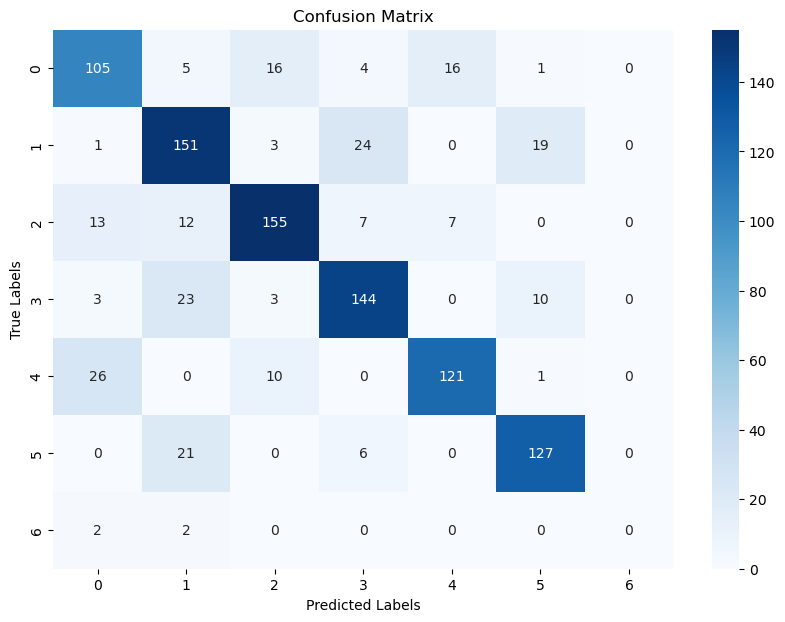

In [51]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Random Forest

In [52]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
feature_names = [i for i in range(X_train.shape[1])]
feature_importances = pd.DataFrame(importances, index=feature_names, columns=["Importance"]).sort_values(by="Importance", ascending=False)

In [53]:
accuracy = rf.score(X_test, y_test)
print(f"Accuracy of RandomForestClassifier: {accuracy:.4f}")

Accuracy of RandomForestClassifier: 0.9171


In [54]:
feature_importances.head()

,Importance
41,0.046452
56,0.034048
60,0.024543
69,0.023105
11,0.022655


In [55]:
with open('data/0_raw/idx2depth.json', 'r') as json_file:
    idx2depth = json.load(json_file)

In [56]:
idx2depth

{'0': 660,
 '1': 1320,
 '2': 1320,
 '3': 1340,
 '4': 1680,
 '5': 1820,
 '6': 2140,
 '7': 2220,
 '8': 2240,
 '9': 2260,
 '10': 2280,
 '11': 2300,
 '12': 2320,
 '13': 2340,
 '14': 2380,
 '15': 2360,
 '16': 2400,
 '17': 2420,
 '18': 2440,
 '19': 2440,
 '20': 2460,
 '21': 2480,
 '22': 2480,
 '23': 2500,
 '24': 2520,
 '25': 2520,
 '26': 2540,
 '27': 2540,
 '28': 2580,
 '29': 2580,
 '30': 2580,
 '31': 2600,
 '32': 2600,
 '33': 2600,
 '34': 2600,
 '35': 2640,
 '36': 2640,
 '37': 2660,
 '38': 2680,
 '39': 2720,
 '40': 2880,
 '41': 2960,
 '42': 3200,
 '43': 2380,
 '44': 2560,
 '45': 2640,
 '46': 2660,
 '47': 2720,
 '48': 2740,
 '49': 2580,
 '50': 2580,
 '51': 2460,
 '52': 2680,
 '53': 840,
 '54': 480,
 '55': 480,
 '56': 2860,
 '57': 200,
 '58': 3220,
 '59': 3180,
 '60': 2980,
 '61': 1060,
 '62': 1120,
 '63': 1060,
 '64': 1080,
 '65': 1680,
 '66': 1880,
 '67': 2100,
 '68': 2160,
 '69': 2180,
 '70': 2280,
 '71': 2360,
 '72': 2700,
 '73': 2820,
 '74': 3380}

In [57]:
idx2depth_int_keys = {int(k): v for k, v in idx2depth.items()}
feature_importances['Depth'] = feature_importances.index.map(idx2depth_int_keys)
norm = mcolors.Normalize(vmin=feature_importances['Importance'].min(), vmax=feature_importances['Importance'].max())

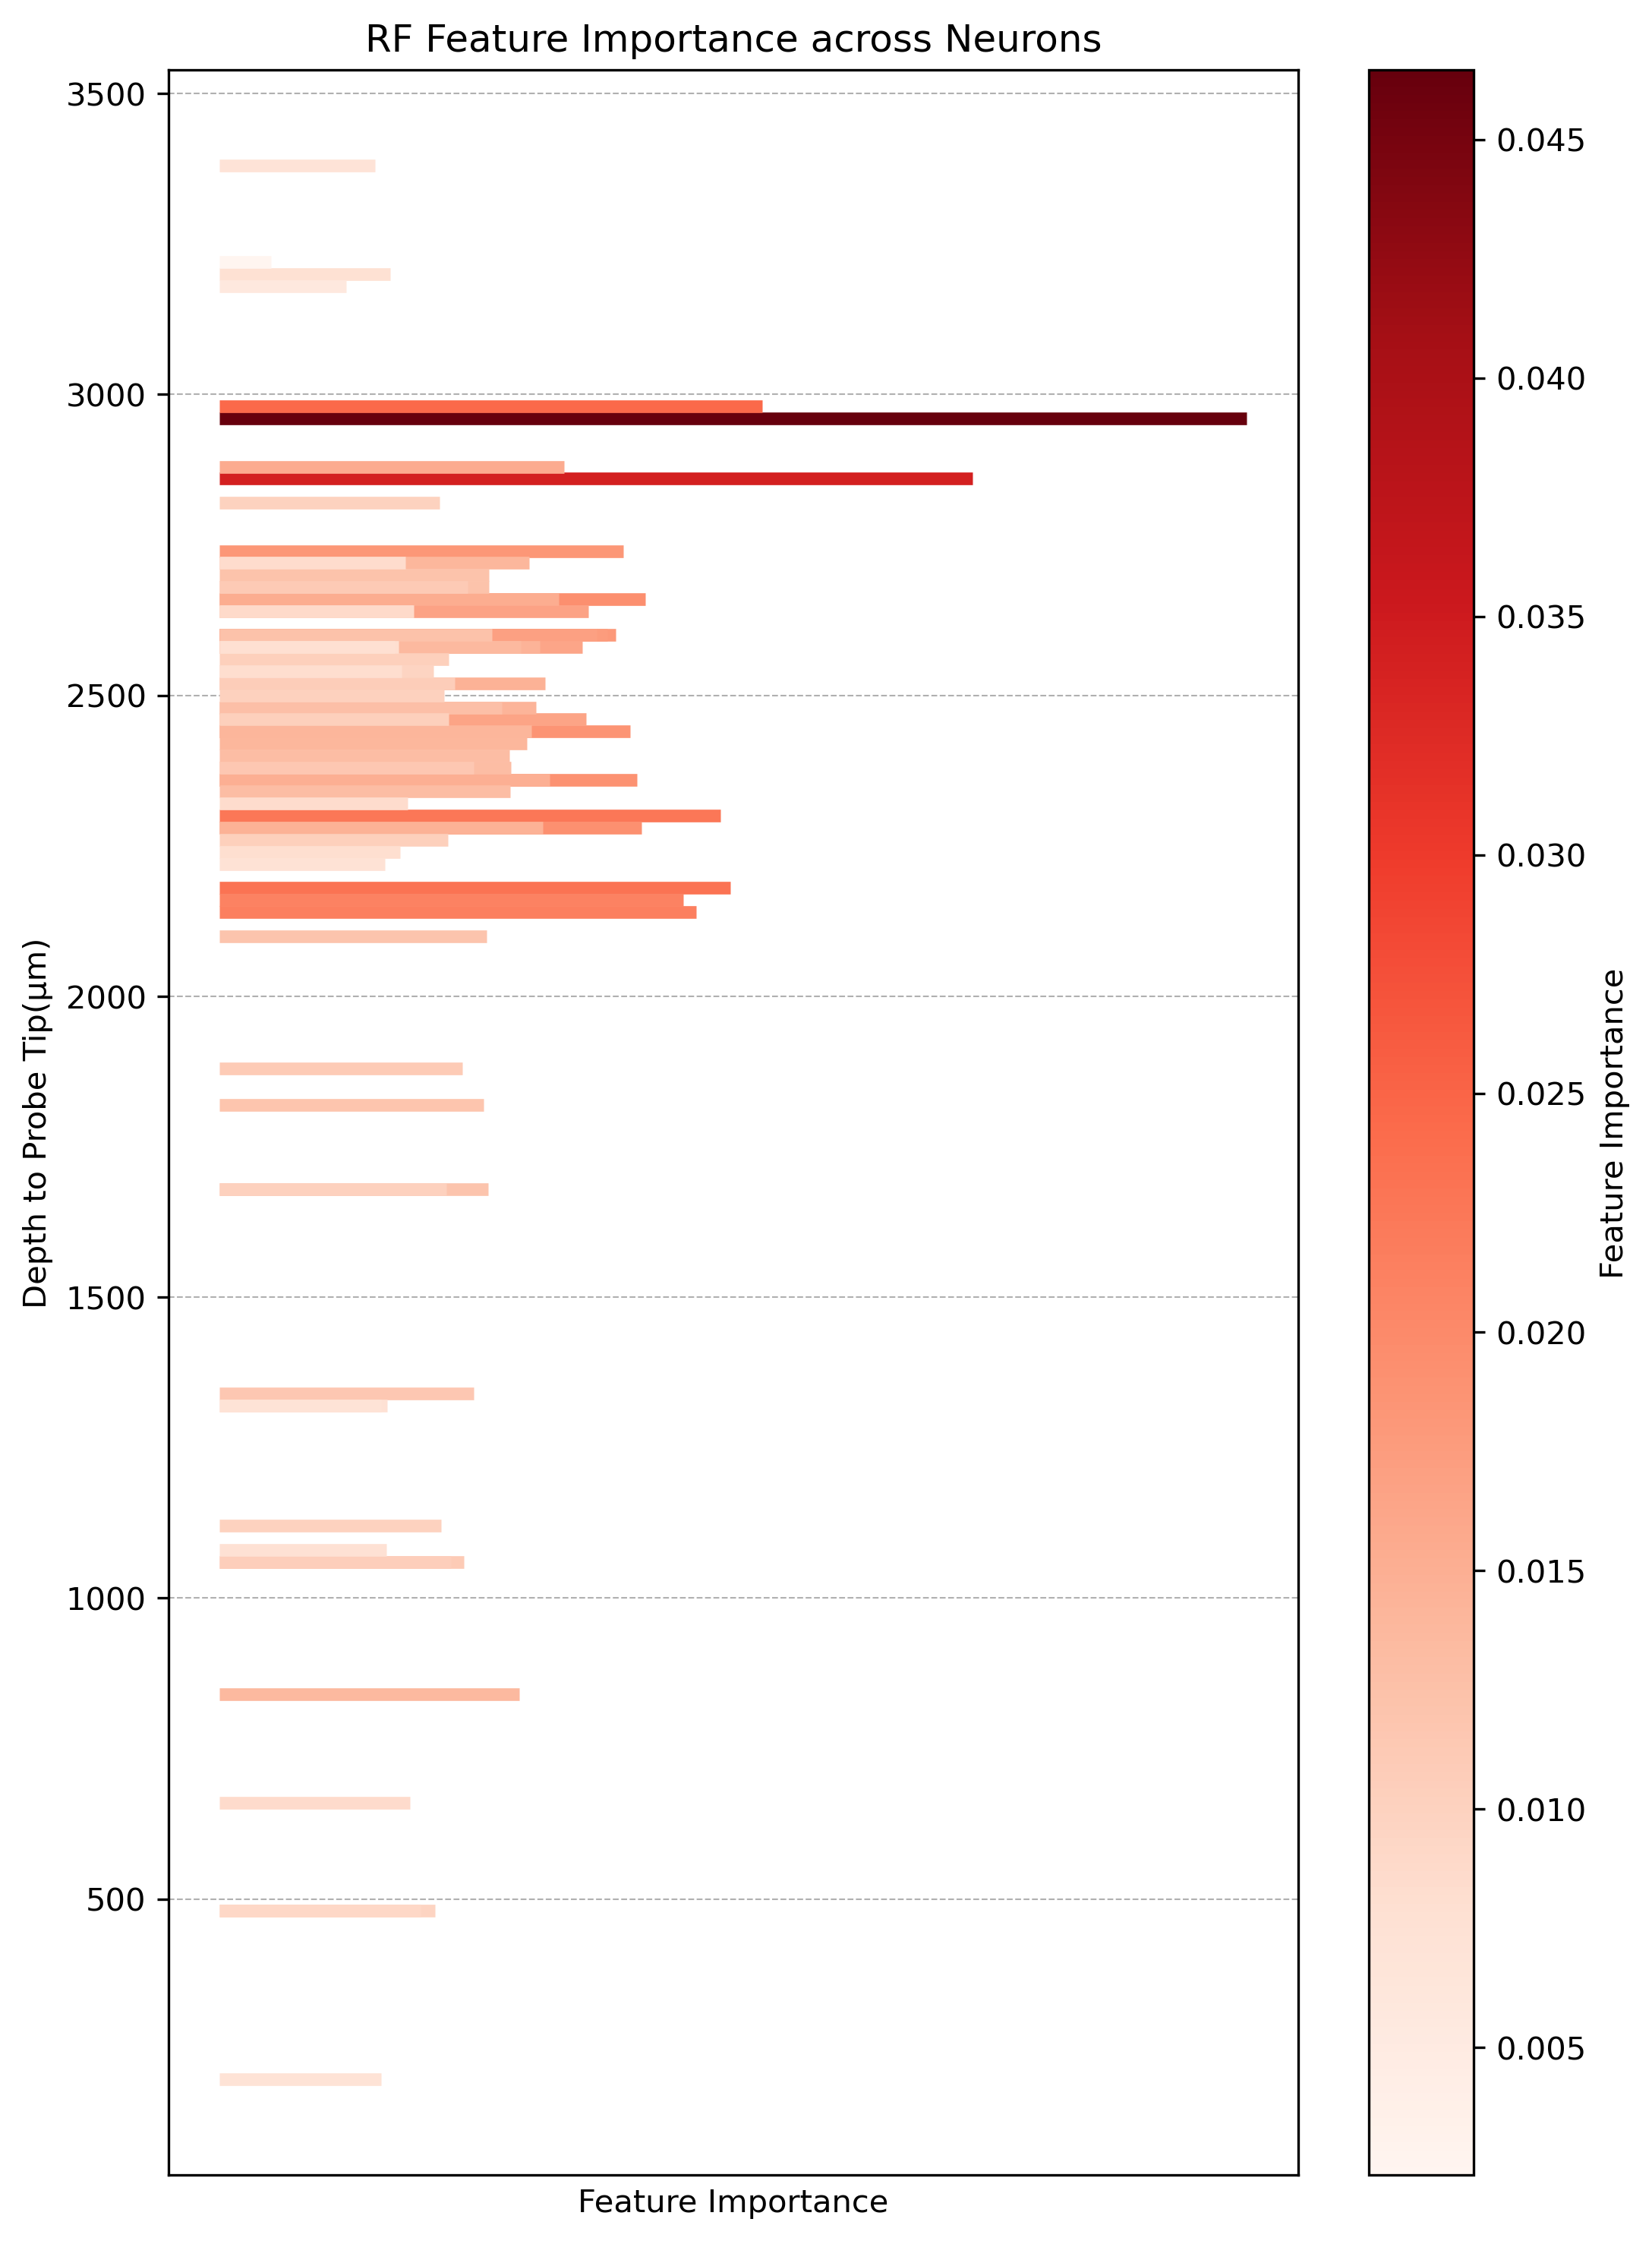

In [58]:
# Create normalization for the colormap
norm = plt.Normalize(feature_importances['Importance'].min(), 
                    feature_importances['Importance'].max())

# Create plot
colormap = plt.cm.Reds
fig, ax = plt.subplots(figsize=(8, 12), dpi=300)

# Plot feature importances as horizontal lines
for idx, row in feature_importances.iterrows():
    ax.hlines(
        y=row['Depth'],
        xmin=0,
        xmax=row['Importance'],
        color=colormap(norm(row['Importance'])),
        linewidth=4
    )

# Create a color bar
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=colormap), 
            ax=ax, label='Feature Importance')

# Label the axes
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Depth to Probe Tip(μm)')
ax.set_title('RF Feature Importance across Neurons')

# Remove x-axis labels and ticks
ax.set_xticks([])

# Show the grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')

# Save plot
# plt.savefig('feature_importance_across_neurons.pdf', dpi=300, bbox_inches='tight')
plt.savefig('result_RF_firing_frequency.pdf', dpi=300, bbox_inches='tight')
plt.show()

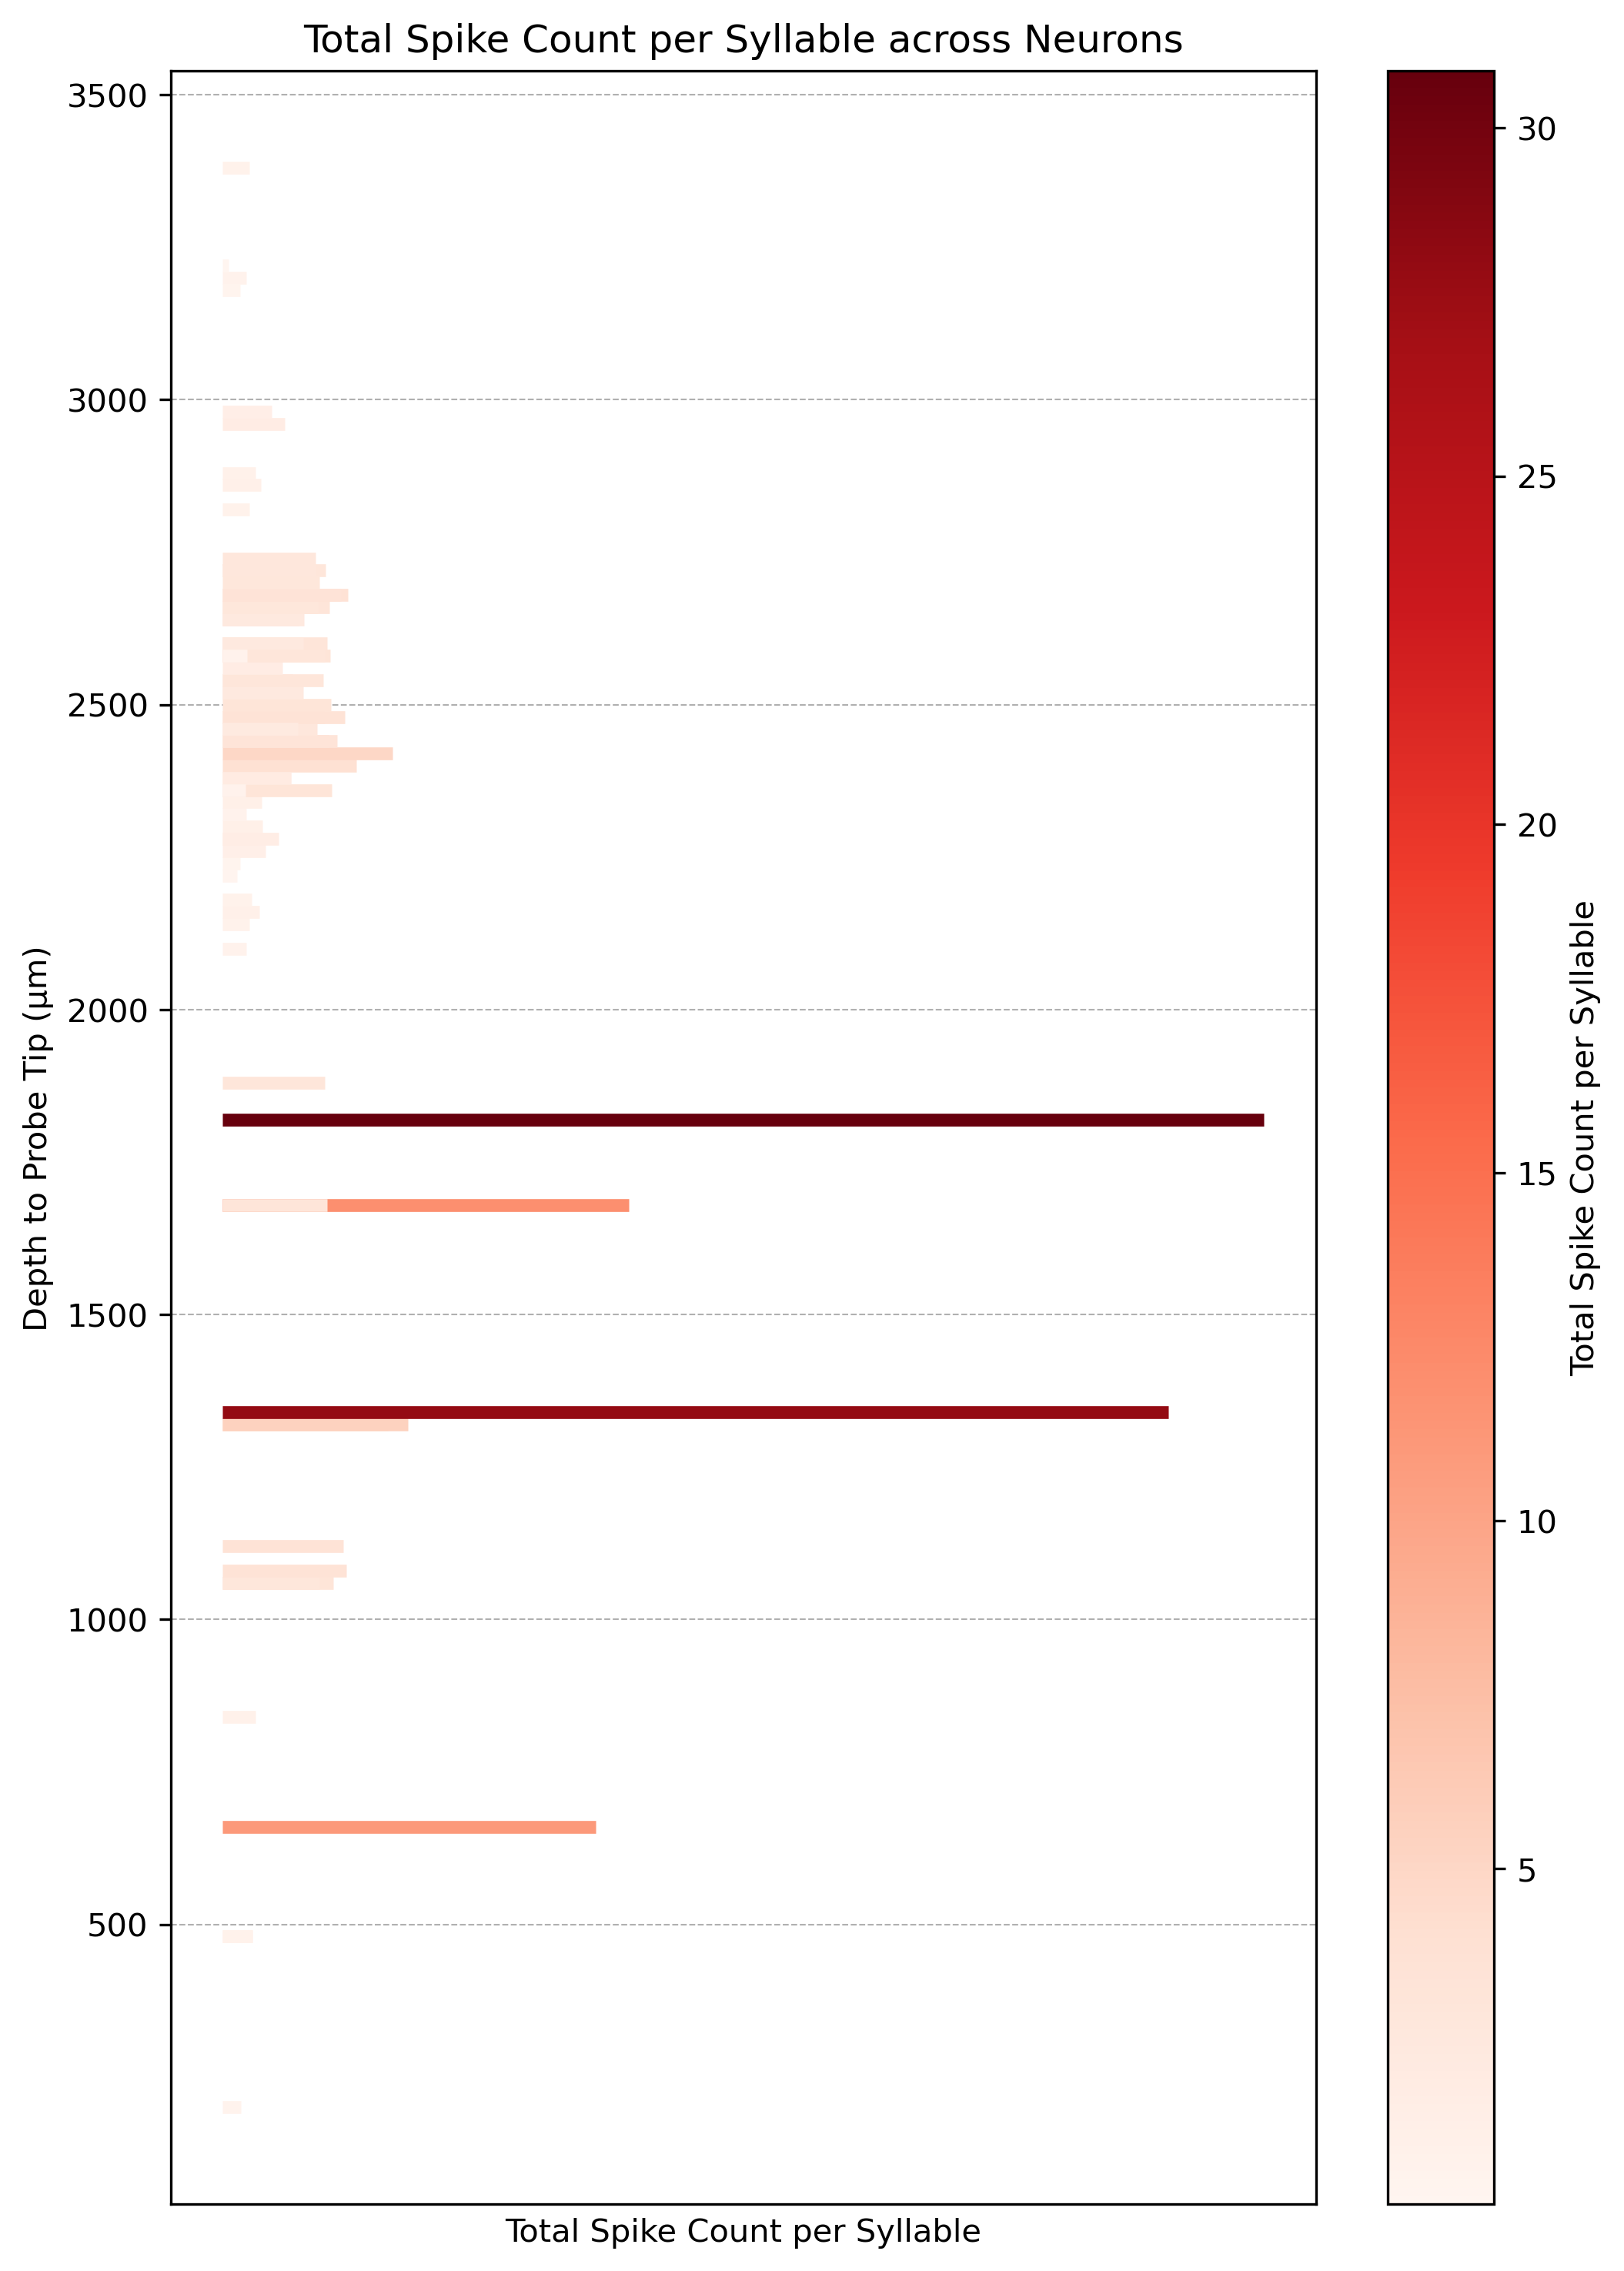

In [36]:
# Calculate mean firing rates for each neuron (excluding the label column)
X_mean = X[:, :75].mean(axis=0)  # Average across samples

# Create DataFrame with depths and mean firing rates
mean_firing_rates = pd.DataFrame({
    'Depth': [idx2depth[str(i)] for i in range(75)],
    'Firing_Rate': X_mean
})

# Create color normalization based on firing rates
norm = plt.Normalize(mean_firing_rates['Firing_Rate'].min(), 
                    mean_firing_rates['Firing_Rate'].max())

# Create plot
colormap = plt.cm.Reds
fig, ax = plt.subplots(figsize=(8, 12), dpi=300)

# Plot mean firing rates as horizontal lines
for idx, row in mean_firing_rates.iterrows():
    ax.hlines(
        y=row['Depth'],
        xmin=0,
        xmax=row['Firing_Rate'],
        color=colormap(norm(row['Firing_Rate'])),
        linewidth=4
    )

# Create a color bar
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=colormap), 
            ax=ax, label='Total Spike Count per Syllable')

# Label the axes
ax.set_xlabel('Total Spike Count per Syllable')
ax.set_ylabel('Depth to Probe Tip (μm)')
ax.set_title('Total Spike Count per Syllable across Neurons')

# Remove x-axis labels and ticks
ax.set_xticks([])

# Show the grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')

# Save plot
plt.savefig('total_spike_count_across_neurons.pdf', dpi=300, bbox_inches='tight')
plt.show()

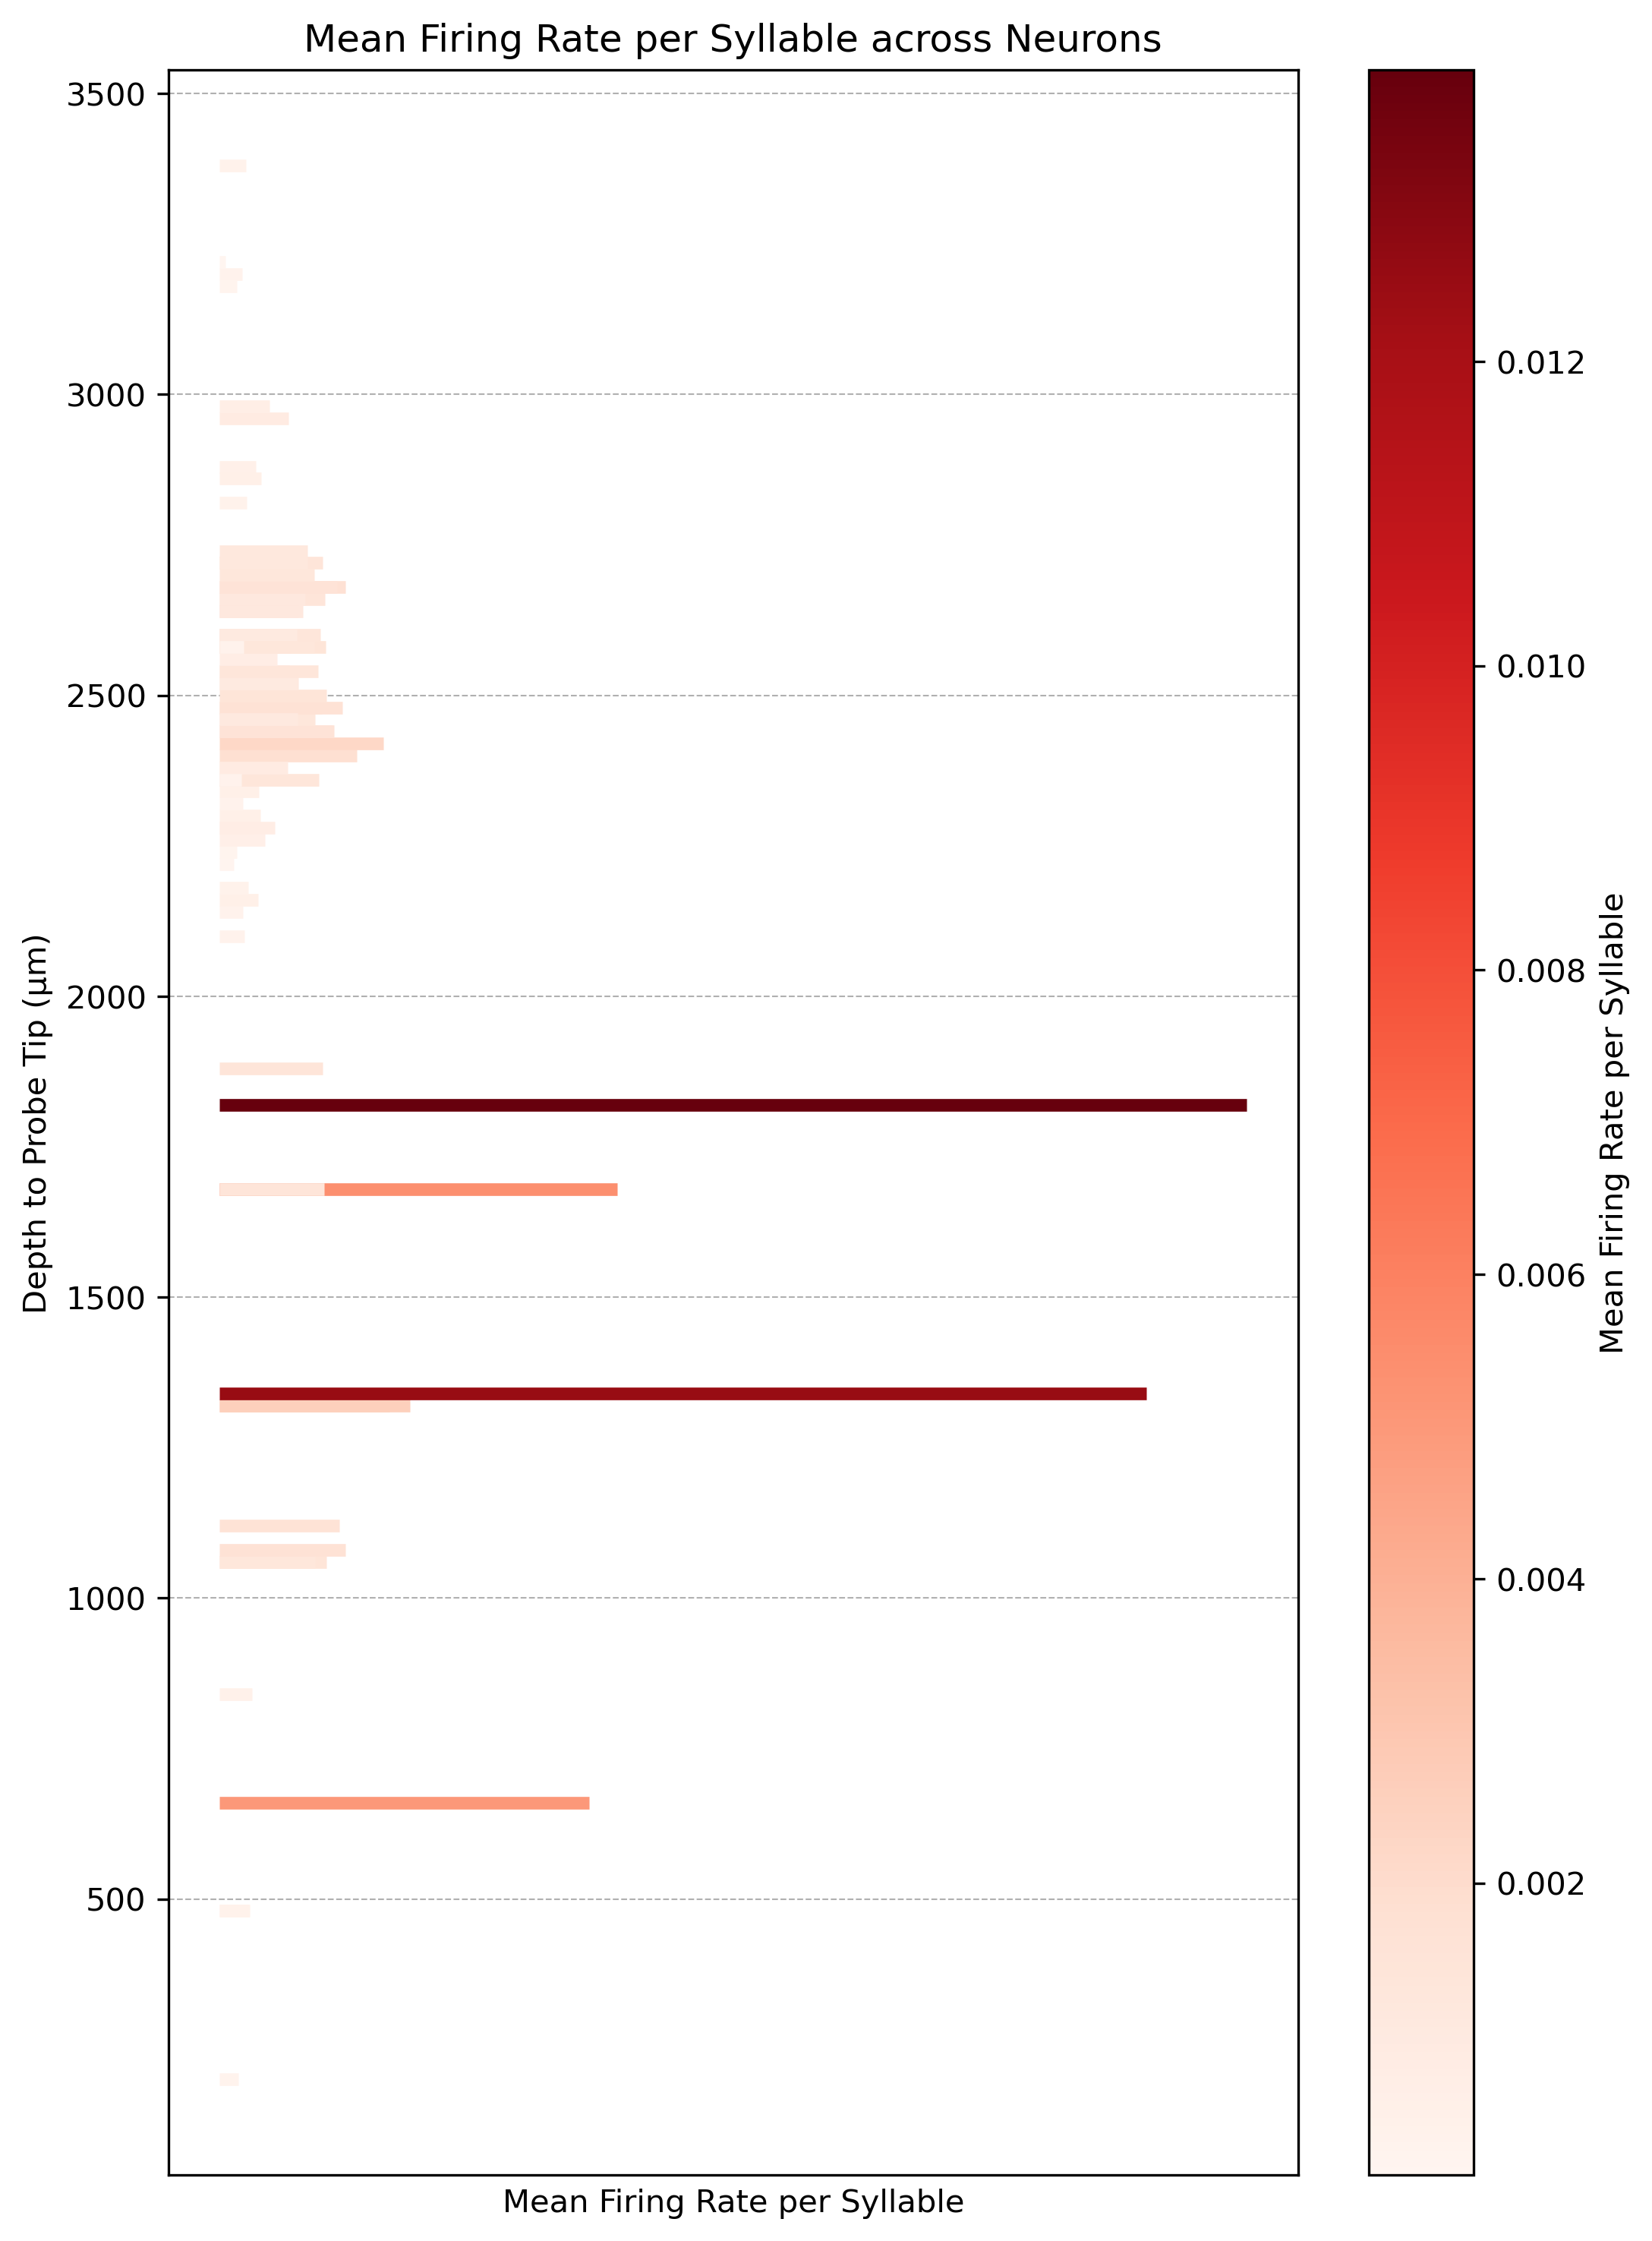


Mean Firing Rates by Depth:
    Depth  Firing_Rate
5    1820     0.013915
3    1340     0.012554
4    1680     0.005386
0     660     0.005004
2    1320     0.002577
..    ...          ...
57    200     0.000250
59   3180     0.000235
8    2240     0.000233
7    2220     0.000187
58   3220     0.000080

[75 rows x 2 columns]


In [37]:
# Calculate mean firing rates for each neuron (excluding the label column)
X_mean = X_N[:, :75].mean(axis=0)  # Average across samples

# Create DataFrame with depths and mean firing rates
mean_firing_rates = pd.DataFrame({
    'Depth': [idx2depth[str(i)] for i in range(75)],
    'Firing_Rate': X_mean
})

# Create color normalization based on firing rates
norm = plt.Normalize(mean_firing_rates['Firing_Rate'].min(), 
                    mean_firing_rates['Firing_Rate'].max())

# Create plot
colormap = plt.cm.Reds
fig, ax = plt.subplots(figsize=(8, 12), dpi=300)

# Plot mean firing rates as horizontal lines
for idx, row in mean_firing_rates.iterrows():
    ax.hlines(
        y=row['Depth'],
        xmin=0,
        xmax=row['Firing_Rate'],
        color=colormap(norm(row['Firing_Rate'])),
        linewidth=4
    )

# Create a color bar
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=colormap), 
            ax=ax, label='Mean Firing Rate per Syllable')

# Label the axes
ax.set_xlabel('Mean Firing Rate per Syllable')
ax.set_ylabel('Depth to Probe Tip (μm)')
ax.set_title('Mean Firing Rate per Syllable across Neurons')

# Remove x-axis labels and ticks
ax.set_xticks([])

# Show the grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')

# Save plot
plt.savefig('mean_firing_rate_across_neurons.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("\nMean Firing Rates by Depth:")
print(mean_firing_rates.sort_values('Firing_Rate', ascending=False))

In [106]:
feature_importances

,Importance,Depth
5,0.146379,1820
3,0.134743,1340
0,0.096441,660
4,0.049939,1680
61,0.018760,1060
...,...,...
57,0.002686,200
59,0.002350,3180
8,0.002300,2240
7,0.002033,2220


# XGBoost

In [134]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200]
}

xgb_model = XGBClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

c:\Users\askrb\miniforge3\envs\neuro2voc_env\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200]},
             scoring='accuracy')

In [135]:
best_model = grid_search.best_estimator_
importances = best_model.feature_importances_
feature_names = [i for i in range(X_train.shape[1])]
feature_importances = pd.DataFrame(importances, index=feature_names, columns=["Importance"]).sort_values(by="Importance", ascending=False)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best cross-validation score: 0.9620013632103603


# Clustering on data

In [ ]:
feature_importances

,Importance,Depth
24,0.044836,2520
26,0.043221,2540
20,0.042568,2460
46,0.040054,2660
19,0.034640,2440
...,...,...
31,0.000000,2600
32,0.000000,2600
36,0.000000,2640
1,0.000000,1320


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=7)
kmeans.fit(X_scaled)
clusters = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
ari = adjusted_rand_score(y, clusters)
mi = mutual_info_score(y, clusters)

print(f"Adjusted Rand Index: {ari}")
print(f"Mutual Information: {mi}")

Adjusted Rand Index: -0.0006333801458364858
Mutual Information: 0.11767863051039311


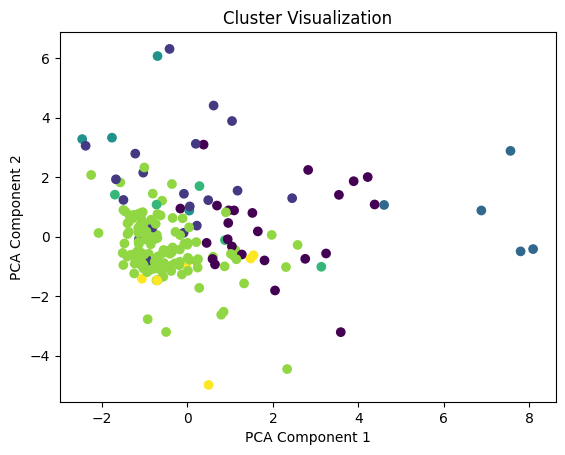

In [ ]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title("Cluster Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# Clustering on Normalized data

# Clustering without PCA

In [ ]:
kmeans = KMeans(n_clusters=7)
clusters = kmeans.fit_predict(X)
silhouette_avg = silhouette_score(X, clusters)
print(f"Silhouette Score: {silhouette_avg:.2f}")
adjusted_rand = adjusted_rand_score(y, clusters)
print(f"Adjusted Rand Index: {adjusted_rand:.2f}")

Silhouette Score: 0.06
Adjusted Rand Index: 0.03


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# Learning Curve

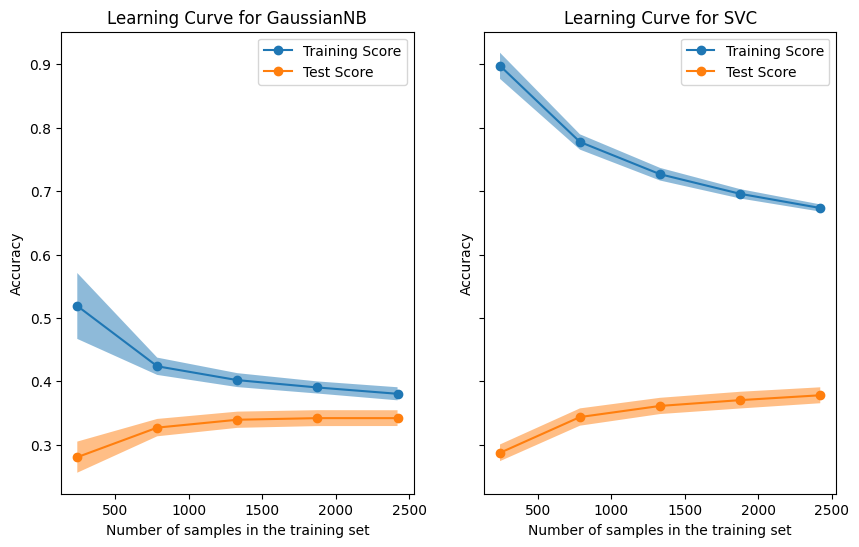

In [ ]:
naive_bayes = GaussianNB()
svc = SVC(kernel="rbf", C=10, gamma='scale')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.3, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([naive_bayes, svc]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

plt.show()


In [ ]:
naive_bayes = GaussianNB()
# svc = SVC(kernel="rbf") # C: 1, gamma: scaled
svc = SVC(kernel="linear") # C: 1, gamma: scaled

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": X_N,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.3, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([naive_bayes, svc]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

plt.show()

# Each neuron as an individual predictor

In [39]:
# X = combined_data.numpy()
X = combined_data_normalized.numpy()
y = combined_labels.numpy()

In [40]:
def evaluate_channel(channel_data, labels):
    X_train, X_test, y_train, y_test = train_test_split(
        channel_data.reshape(-1, 1), labels, test_size=0.2, random_state=42
    )

    # SVM
    svm_model = SVC(kernel='rbf', random_state=42)
    svm_model.fit(X_train, y_train)
    svm_accuracy = accuracy_score(y_test, svm_model.predict(X_test))

    # Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_accuracy = accuracy_score(y_test, rf_model.predict(X_test))

    # XGBoost
    xgb_model = XGBClassifier(random_state=42)
    xgb_model.fit(X_train, y_train)
    xgb_accuracy = accuracy_score(y_test, xgb_model.predict(X_test))

    return svm_accuracy, rf_accuracy, xgb_accuracy

In [41]:
results = []
for i in range(X.shape[1]):  # loop thru all 75 channels
    channel_data = X[:, i]
    svm_acc, rf_acc, xgb_acc = evaluate_channel(channel_data, y)
    results.append((i, svm_acc, rf_acc, xgb_acc))

# sort results by SVM accuracy
results.sort(key=lambda x: x[1], reverse=True)

# print top 10
print("Top 10 channels by SVM accuracy:")
for i, svm_acc, rf_acc, xgb_acc in results[:10]:
    print(f"Channel {i}: SVM Accuracy = {svm_acc:.4f}, RF Accuracy = {rf_acc:.4f}, XGB Accuracy = {xgb_acc:.4f}")

# best channel
best_channel = results[0][0]
print(f"\nBest predicting channel: {best_channel}")

# use best for prediction
best_channel_data = X[:, best_channel].reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(best_channel_data, y, test_size=0.2, random_state=42)

# final models on best channel
final_svm = SVC(kernel='rbf', random_state=42)
final_svm.fit(X_train, y_train)
final_svm_acc = accuracy_score(y_test, final_svm.predict(X_test))

final_rf = RandomForestClassifier(n_estimators=100, random_state=42)
final_rf.fit(X_train, y_train)
final_rf_acc = accuracy_score(y_test, final_rf.predict(X_test))

final_xgb = XGBClassifier(random_state=42)
final_xgb.fit(X_train, y_train)
final_xgb_acc = accuracy_score(y_test, final_xgb.predict(X_test))

print(f"\nFinal SVM accuracy on best channel: {final_svm_acc:.4f}")
print(f"Final RF accuracy on best channel: {final_rf_acc:.4f}")
print(f"Final XGB accuracy on best channel: {final_xgb_acc:.4f}")

Top 10 channels by SVM accuracy:
Channel 56: SVM Accuracy = 0.3902, RF Accuracy = 0.6676, XGB Accuracy = 0.6416
Channel 41: SVM Accuracy = 0.3844, RF Accuracy = 0.6676, XGB Accuracy = 0.6503
Channel 7: SVM Accuracy = 0.3699, RF Accuracy = 0.4205, XGB Accuracy = 0.4205
Channel 8: SVM Accuracy = 0.3613, RF Accuracy = 0.4422, XGB Accuracy = 0.4408
Channel 36: SVM Accuracy = 0.3497, RF Accuracy = 0.6214, XGB Accuracy = 0.6098
Channel 42: SVM Accuracy = 0.3497, RF Accuracy = 0.5159, XGB Accuracy = 0.5231
Channel 67: SVM Accuracy = 0.3497, RF Accuracy = 0.5014, XGB Accuracy = 0.4884
Channel 12: SVM Accuracy = 0.3367, RF Accuracy = 0.4957, XGB Accuracy = 0.4913
Channel 71: SVM Accuracy = 0.3324, RF Accuracy = 0.4538, XGB Accuracy = 0.4552
Channel 19: SVM Accuracy = 0.3309, RF Accuracy = 0.6517, XGB Accuracy = 0.5983

Best predicting channel: 56

Final SVM accuracy on best channel: 0.3902
Final RF accuracy on best channel: 0.6676
Final XGB accuracy on best channel: 0.6416


In [42]:
with open('data/0_raw/idx2depth.json', 'r') as json_file:
    idx2depth = json.load(json_file)

In [43]:
top_10_results = results
# top_10_results = results[:10]

def get_depth(index):
    str_index = str(index)
    if str_index in idx2depth:
        return idx2depth[str_index]
    else:
        return f"Depth not found for index {index}"

converted_results = []
for index, svm_acc, rf_acc, xgb_acc in top_10_results:
    depth = get_depth(index)
    converted_results.append((index, depth, svm_acc, rf_acc, xgb_acc))

print("Top 10 results with depths:")
for index, depth, svm_acc, rf_acc, xgb_acc in converted_results:
    print(f"Index {index} (Depth: {depth}): SVM Accuracy = {svm_acc:.4f}, RF Accuracy = {rf_acc:.4f}, XGB Accuracy = {xgb_acc:.4f}")

Top 10 results with depths:
Index 56 (Depth: 2860): SVM Accuracy = 0.3902, RF Accuracy = 0.6676, XGB Accuracy = 0.6416
Index 41 (Depth: 2960): SVM Accuracy = 0.3844, RF Accuracy = 0.6676, XGB Accuracy = 0.6503
Index 7 (Depth: 2220): SVM Accuracy = 0.3699, RF Accuracy = 0.4205, XGB Accuracy = 0.4205
Index 8 (Depth: 2240): SVM Accuracy = 0.3613, RF Accuracy = 0.4422, XGB Accuracy = 0.4408
Index 36 (Depth: 2640): SVM Accuracy = 0.3497, RF Accuracy = 0.6214, XGB Accuracy = 0.6098
Index 42 (Depth: 3200): SVM Accuracy = 0.3497, RF Accuracy = 0.5159, XGB Accuracy = 0.5231
Index 67 (Depth: 2100): SVM Accuracy = 0.3497, RF Accuracy = 0.5014, XGB Accuracy = 0.4884
Index 12 (Depth: 2320): SVM Accuracy = 0.3367, RF Accuracy = 0.4957, XGB Accuracy = 0.4913
Index 71 (Depth: 2360): SVM Accuracy = 0.3324, RF Accuracy = 0.4538, XGB Accuracy = 0.4552
Index 19 (Depth: 2440): SVM Accuracy = 0.3309, RF Accuracy = 0.6517, XGB Accuracy = 0.5983
Index 44 (Depth: 2560): SVM Accuracy = 0.3251, RF Accuracy = 0.6

C:\Users\askrb\AppData\Local\Temp\ipykernel_32416\576928186.py:80: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


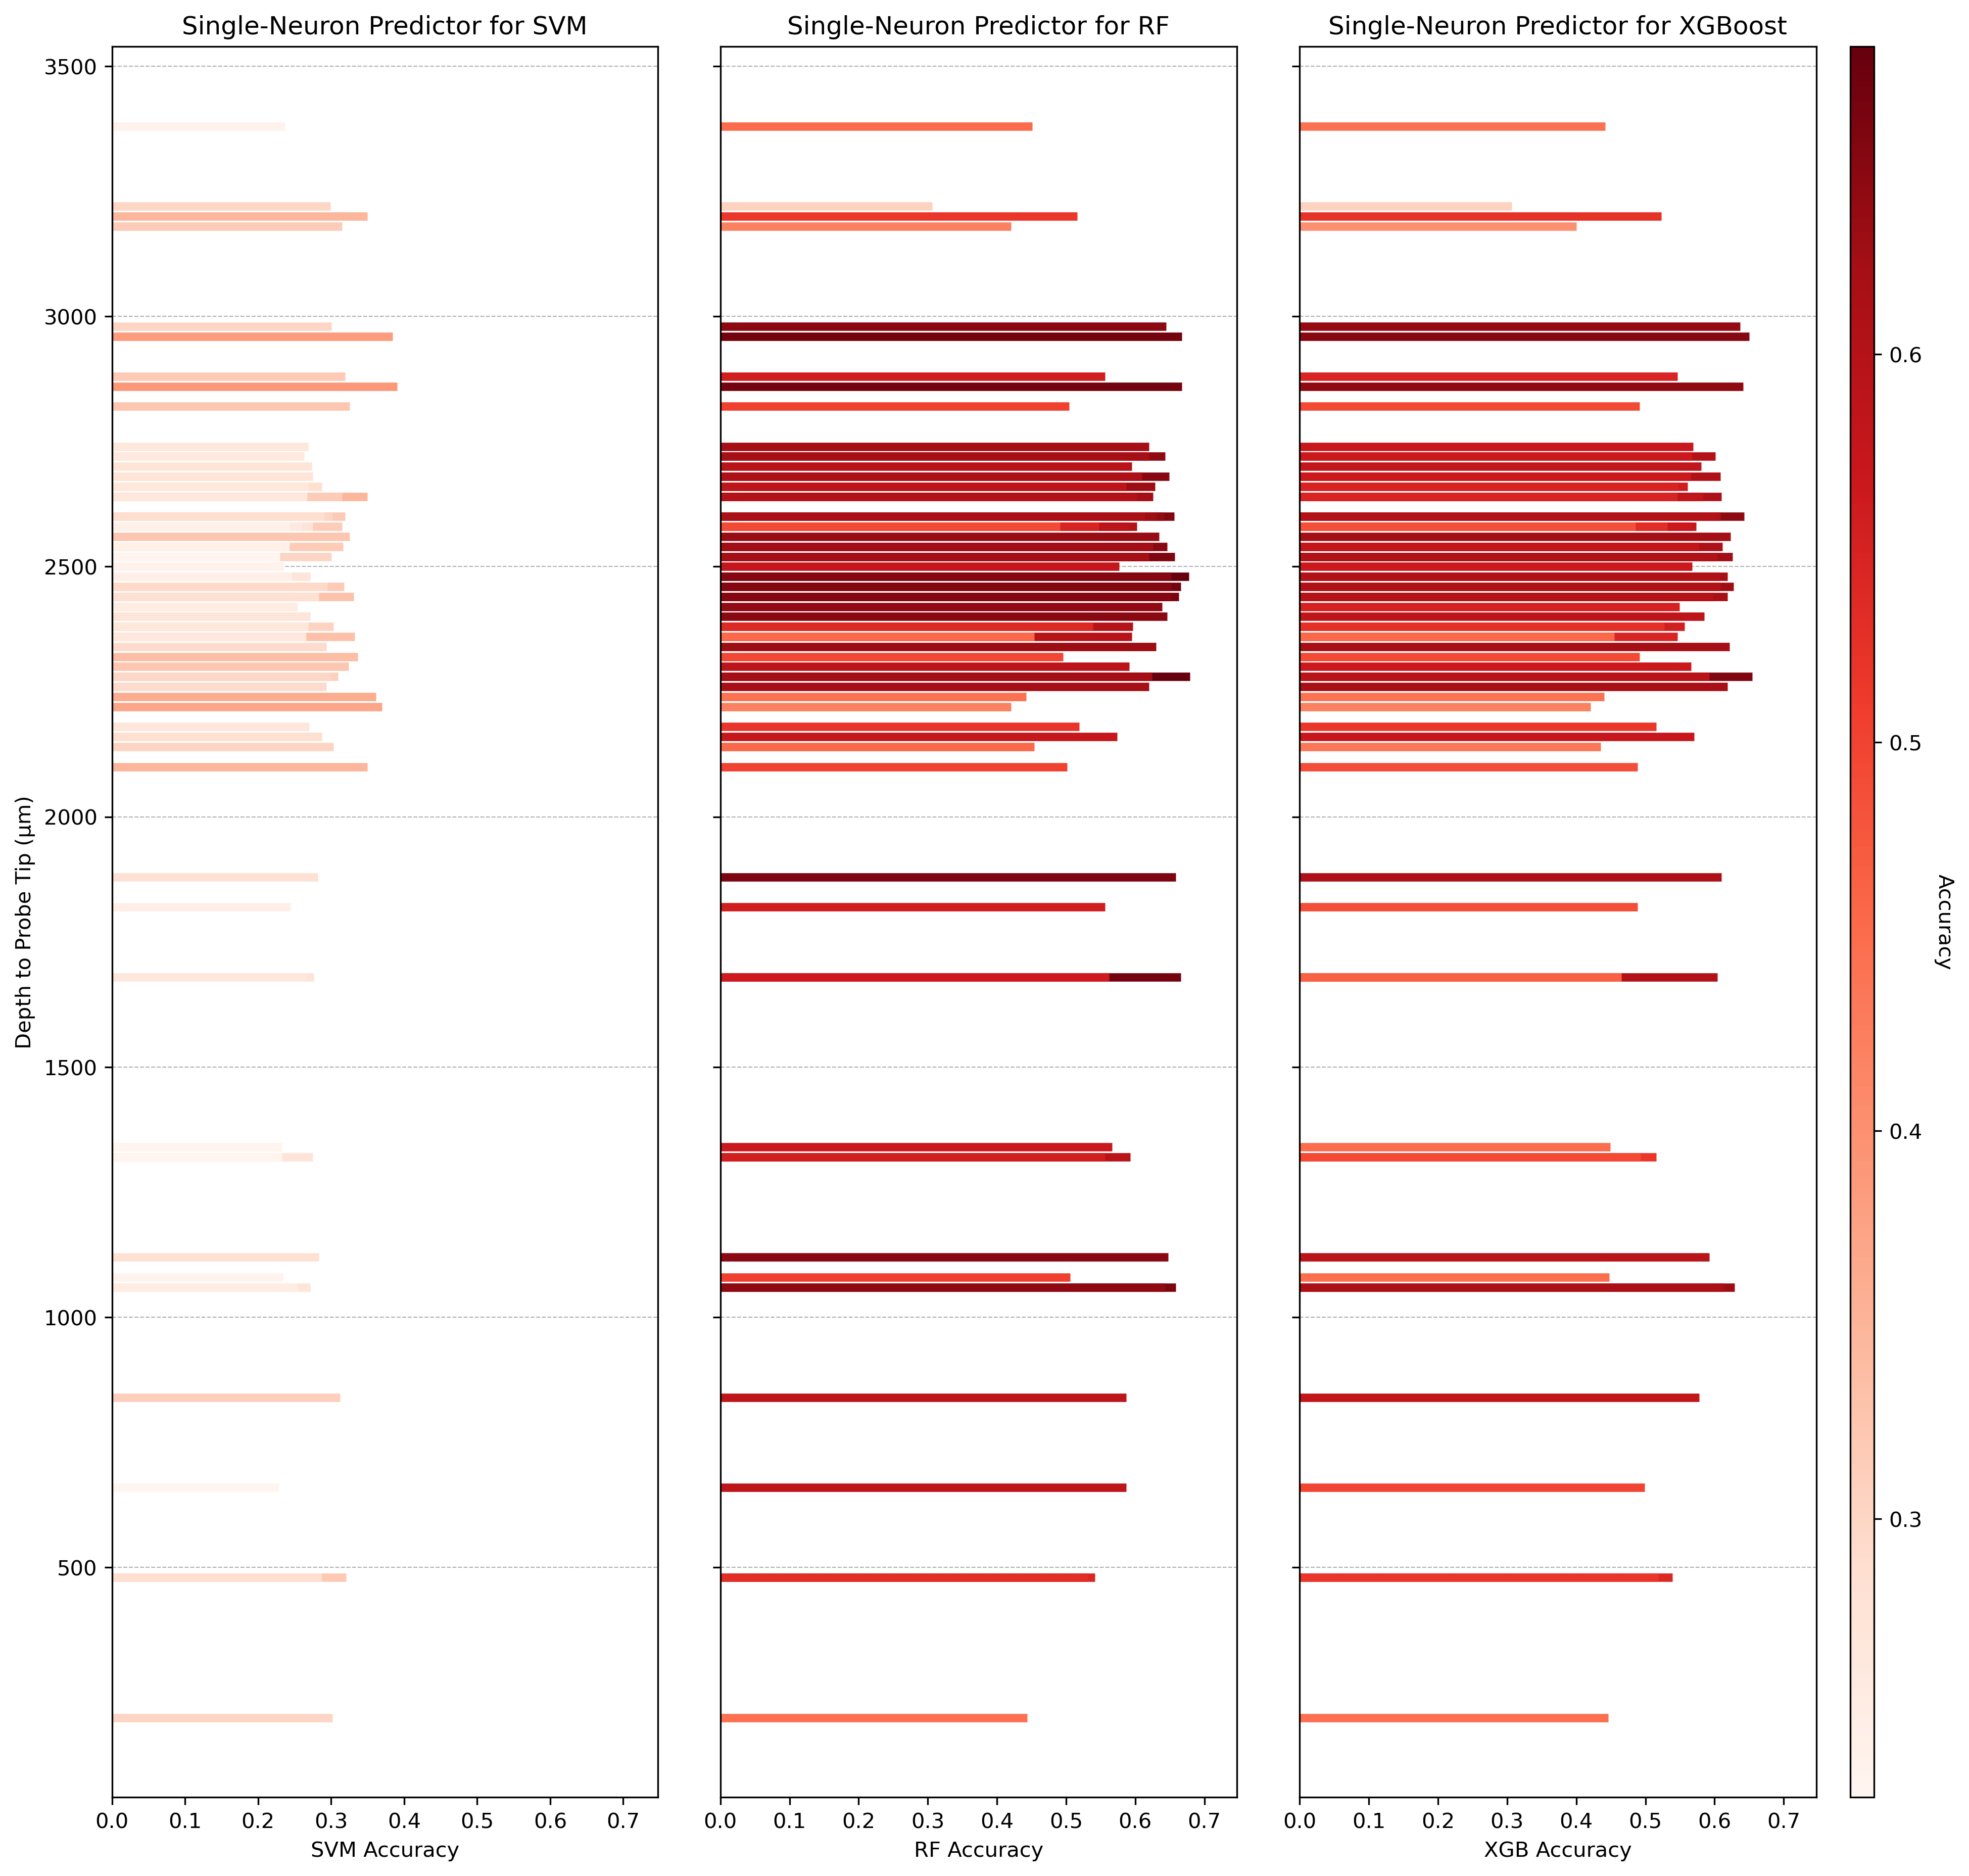

In [66]:
df = pd.DataFrame(converted_results, columns=['Index', 'Depth', 'SVM_Accuracy', 'RF_Accuracy', 'XGB_Accuracy'])
fig = plt.figure(figsize=(15, 15), dpi=300)  # Triple width to fit three plots
gs = GridSpec(1, 61, figure=fig)  # 61 columns to fit three plots and colorbars

# min/max for shared color normalization
all_accuracies = np.concatenate([df['SVM_Accuracy'], df['RF_Accuracy'], df['XGB_Accuracy']])
norm = plt.Normalize(np.min(all_accuracies), np.max(all_accuracies))
colormap = plt.cm.Reds

# SVM Accuracy (left subplot)
df['Importance'] = df['SVM_Accuracy']
df_sorted = df.sort_values('Importance', ascending=False)

# SVM
ax1 = fig.add_subplot(gs[:, :19])  # First 19 columns
for idx, row in df_sorted.iterrows():
    ax1.hlines(
        y=row['Depth'],
        xmin=0,
        xmax=row['Importance'],
        colors=colormap(norm(row['Importance'])),
        linewidth=4
    )

ax1.set_xlabel('SVM Accuracy')
ax1.set_ylabel('Depth to Probe Tip (μm)')
ax1.set_title('Single-Neuron Predictor for SVM')
ax1.set_xlim(0, max(all_accuracies) * 1.1)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')

# RF Accuracy
df['Importance'] = df['RF_Accuracy']
df_sorted = df.sort_values('Importance', ascending=False)

# RF
ax2 = fig.add_subplot(gs[:, 21:39])  # Columns 21-39
for idx, row in df_sorted.iterrows():
    ax2.hlines(
        y=row['Depth'],
        xmin=0,
        xmax=row['Importance'],
        colors=colormap(norm(row['Importance'])),
        linewidth=4
    )

ax2.set_xlabel('RF Accuracy')
ax2.set_title('Single-Neuron Predictor for RF')
ax2.set_xlim(0, max(all_accuracies) * 1.1)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')
ax2.set_yticklabels([])

# XGB Accuracy
df['Importance'] = df['XGB_Accuracy']
df_sorted = df.sort_values('Importance', ascending=False)

# XGB
ax3 = fig.add_subplot(gs[:, 41:59])  # Columns 41-59
for idx, row in df_sorted.iterrows():
    ax3.hlines(
        y=row['Depth'],
        xmin=0,
        xmax=row['Importance'],
        colors=colormap(norm(row['Importance'])),
        linewidth=4
    )

ax3.set_xlabel('XGB Accuracy')
ax3.set_title('Single-Neuron Predictor for XGBoost')
ax3.set_xlim(0, max(all_accuracies) * 1.1)
ax3.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')
ax3.set_yticklabels([])

# Colorbar
cax = fig.add_subplot(gs[:, 60])  # Last column
sm = plt.cm.ScalarMappable(norm=norm, cmap=colormap)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax, fraction=0.1, aspect=40)
cbar.set_label('Accuracy', rotation=270, labelpad=15)

plt.tight_layout()
plt.savefig('accuracy_across_neurons.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [161]:
def count_depths_in_range(data, min_depth, max_depth):
    count = 0
    for item in data:
        depth = item[1]
        if min_depth < depth < max_depth:
            print(depth)
    return count

# Assuming converted_results is your data
result = count_depths_in_range(converted_results, 300, 500)

print(f"Number of data points with depth between 300 and 500: {result}")

SyntaxError: unmatched ')' (4096426290.py, line 4)

In [ ]:
def count_total(data):
    count = 0
    for item in data:
        count += 1
    return count

# Assuming converted_results is your data
result = count_total(converted_results)
result

75

In [ ]:
converted_results

[(56, 2860, 0.3901734104046243, 0.6676300578034682),
 (41, 2960, 0.38439306358381503, 0.6676300578034682),
 (7, 2220, 0.3699421965317919, 0.42052023121387283),
 (8, 2240, 0.36127167630057805, 0.4421965317919075),
 (36, 2640, 0.34971098265895956, 0.6213872832369942),
 (42, 3200, 0.34971098265895956, 0.5158959537572254),
 (67, 2100, 0.34971098265895956, 0.5014450867052023),
 (12, 2320, 0.33670520231213874, 0.4956647398843931),
 (71, 2360, 0.33236994219653176, 0.45375722543352603),
 (19, 2440, 0.3309248554913295, 0.6517341040462428),
 (44, 2560, 0.32514450867052025, 0.634393063583815),
 (73, 2820, 0.32514450867052025, 0.5043352601156069),
 (11, 2300, 0.3236994219653179, 0.5910404624277457),
 (55, 480, 0.3208092485549133, 0.541907514450867),
 (32, 2600, 0.319364161849711, 0.6560693641618497),
 (40, 2880, 0.319364161849711, 0.5563583815028902),
 (51, 2460, 0.3179190751445087, 0.6517341040462428),
 (26, 2540, 0.31647398843930635, 0.6459537572254336),
 (45, 2640, 0.315028901734104, 0.60260115

In [ ]:
from collections import defaultdict

def check_duplicates(data):
    # Dictionaries to store counts
    second_dim_counts = defaultdict(list)
    first_dim_counts = defaultdict(list)

    # Check for duplicates
    for index, item in enumerate(data):
        second_dim_counts[item[1]].append(index)
        first_dim_counts[item[0]].append(index)

    # Print duplicates in second dimension (depth)
    print("Duplicates in the second dimension (depth):")
    for depth, indices in second_dim_counts.items():
        if len(indices) > 1:
            print(f"Depth {depth} appears {len(indices)} times at indices: {indices}")
            for idx in indices:
                print(f"  {data[idx]}")

    print("\nDuplicates in the first dimension (index):")
    for index, indices in first_dim_counts.items():
        if len(indices) > 1:
            print(f"Index {index} appears {len(indices)} times at positions: {indices}")
            for idx in indices:
                print(f"  {data[idx]}")

# Run the function
check_duplicates(converted_results)

Duplicates in the second dimension (depth):
Depth 2640 appears 3 times at indices: [4, 18, 56]
  (36, 2640, 0.34971098265895956, 0.6213872832369942)
  (45, 2640, 0.315028901734104, 0.6026011560693642)
  (35, 2640, 0.26734104046242774, 0.6257225433526011)
Depth 2360 appears 2 times at indices: [8, 58]
  (71, 2360, 0.33236994219653176, 0.45375722543352603)
  (15, 2360, 0.2658959537572254, 0.5953757225433526)
Depth 2440 appears 2 times at indices: [9, 40]
  (19, 2440, 0.3309248554913295, 0.6517341040462428)
  (18, 2440, 0.2832369942196532, 0.6632947976878613)
Depth 480 appears 2 times at indices: [13, 38]
  (55, 480, 0.3208092485549133, 0.541907514450867)
  (54, 480, 0.2875722543352601, 0.5317919075144508)
Depth 2600 appears 4 times at indices: [14, 26, 35, 36]
  (32, 2600, 0.319364161849711, 0.6560693641618497)
  (33, 2600, 0.3020231213872832, 0.6315028901734104)
  (34, 2600, 0.2904624277456647, 0.6141618497109826)
  (31, 2600, 0.28901734104046245, 0.6416184971098265)
Depth 2460 appears 

In [162]:
idx2depth

{'0': 660,
 '1': 1320,
 '2': 1320,
 '3': 1340,
 '4': 1680,
 '5': 1820,
 '6': 2140,
 '7': 2220,
 '8': 2240,
 '9': 2260,
 '10': 2280,
 '11': 2300,
 '12': 2320,
 '13': 2340,
 '14': 2380,
 '15': 2360,
 '16': 2400,
 '17': 2420,
 '18': 2440,
 '19': 2440,
 '20': 2460,
 '21': 2480,
 '22': 2480,
 '23': 2500,
 '24': 2520,
 '25': 2520,
 '26': 2540,
 '27': 2540,
 '28': 2580,
 '29': 2580,
 '30': 2580,
 '31': 2600,
 '32': 2600,
 '33': 2600,
 '34': 2600,
 '35': 2640,
 '36': 2640,
 '37': 2660,
 '38': 2680,
 '39': 2720,
 '40': 2880,
 '41': 2960,
 '42': 3200,
 '43': 2380,
 '44': 2560,
 '45': 2640,
 '46': 2660,
 '47': 2720,
 '48': 2740,
 '49': 2580,
 '50': 2580,
 '51': 2460,
 '52': 2680,
 '53': 840,
 '54': 480,
 '55': 480,
 '56': 2860,
 '57': 200,
 '58': 3220,
 '59': 3180,
 '60': 2980,
 '61': 1060,
 '62': 1120,
 '63': 1060,
 '64': 1080,
 '65': 1680,
 '66': 1880,
 '67': 2100,
 '68': 2160,
 '69': 2180,
 '70': 2280,
 '71': 2360,
 '72': 2700,
 '73': 2820,
 '74': 3380}

# SHAP

In [68]:
with open('data/0_raw/idx2depth.json', 'r') as json_file:
    idx2depth = json.load(json_file)

In [69]:
# Use full dataset
X = X_N
y = y_whole_N

# Train XGBoost model
model = xgb.XGBRegressor(objective="reg:squarederror", max_depth=3)
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [70]:
explainer = shap.TreeExplainer(model)
shap_interaction = explainer.shap_interaction_values(X)

In [71]:
explainer = shap.TreeExplainer(model)
shap_interaction = explainer.shap_interaction_values(X)
mean_shap = np.mean(np.abs(shap_interaction), axis=0)
most_important_idx = np.argmax(np.mean(mean_shap, axis=1))
importance = np.mean(mean_shap[most_important_idx])
depth = idx2depth[str(most_important_idx)]

print(f"Most important neuron: N{most_important_idx} at depth {depth}µm")
print(f"Importance score: {importance:.6f}")

Most important neuron: N41 at depth 2960µm
Importance score: 0.007957


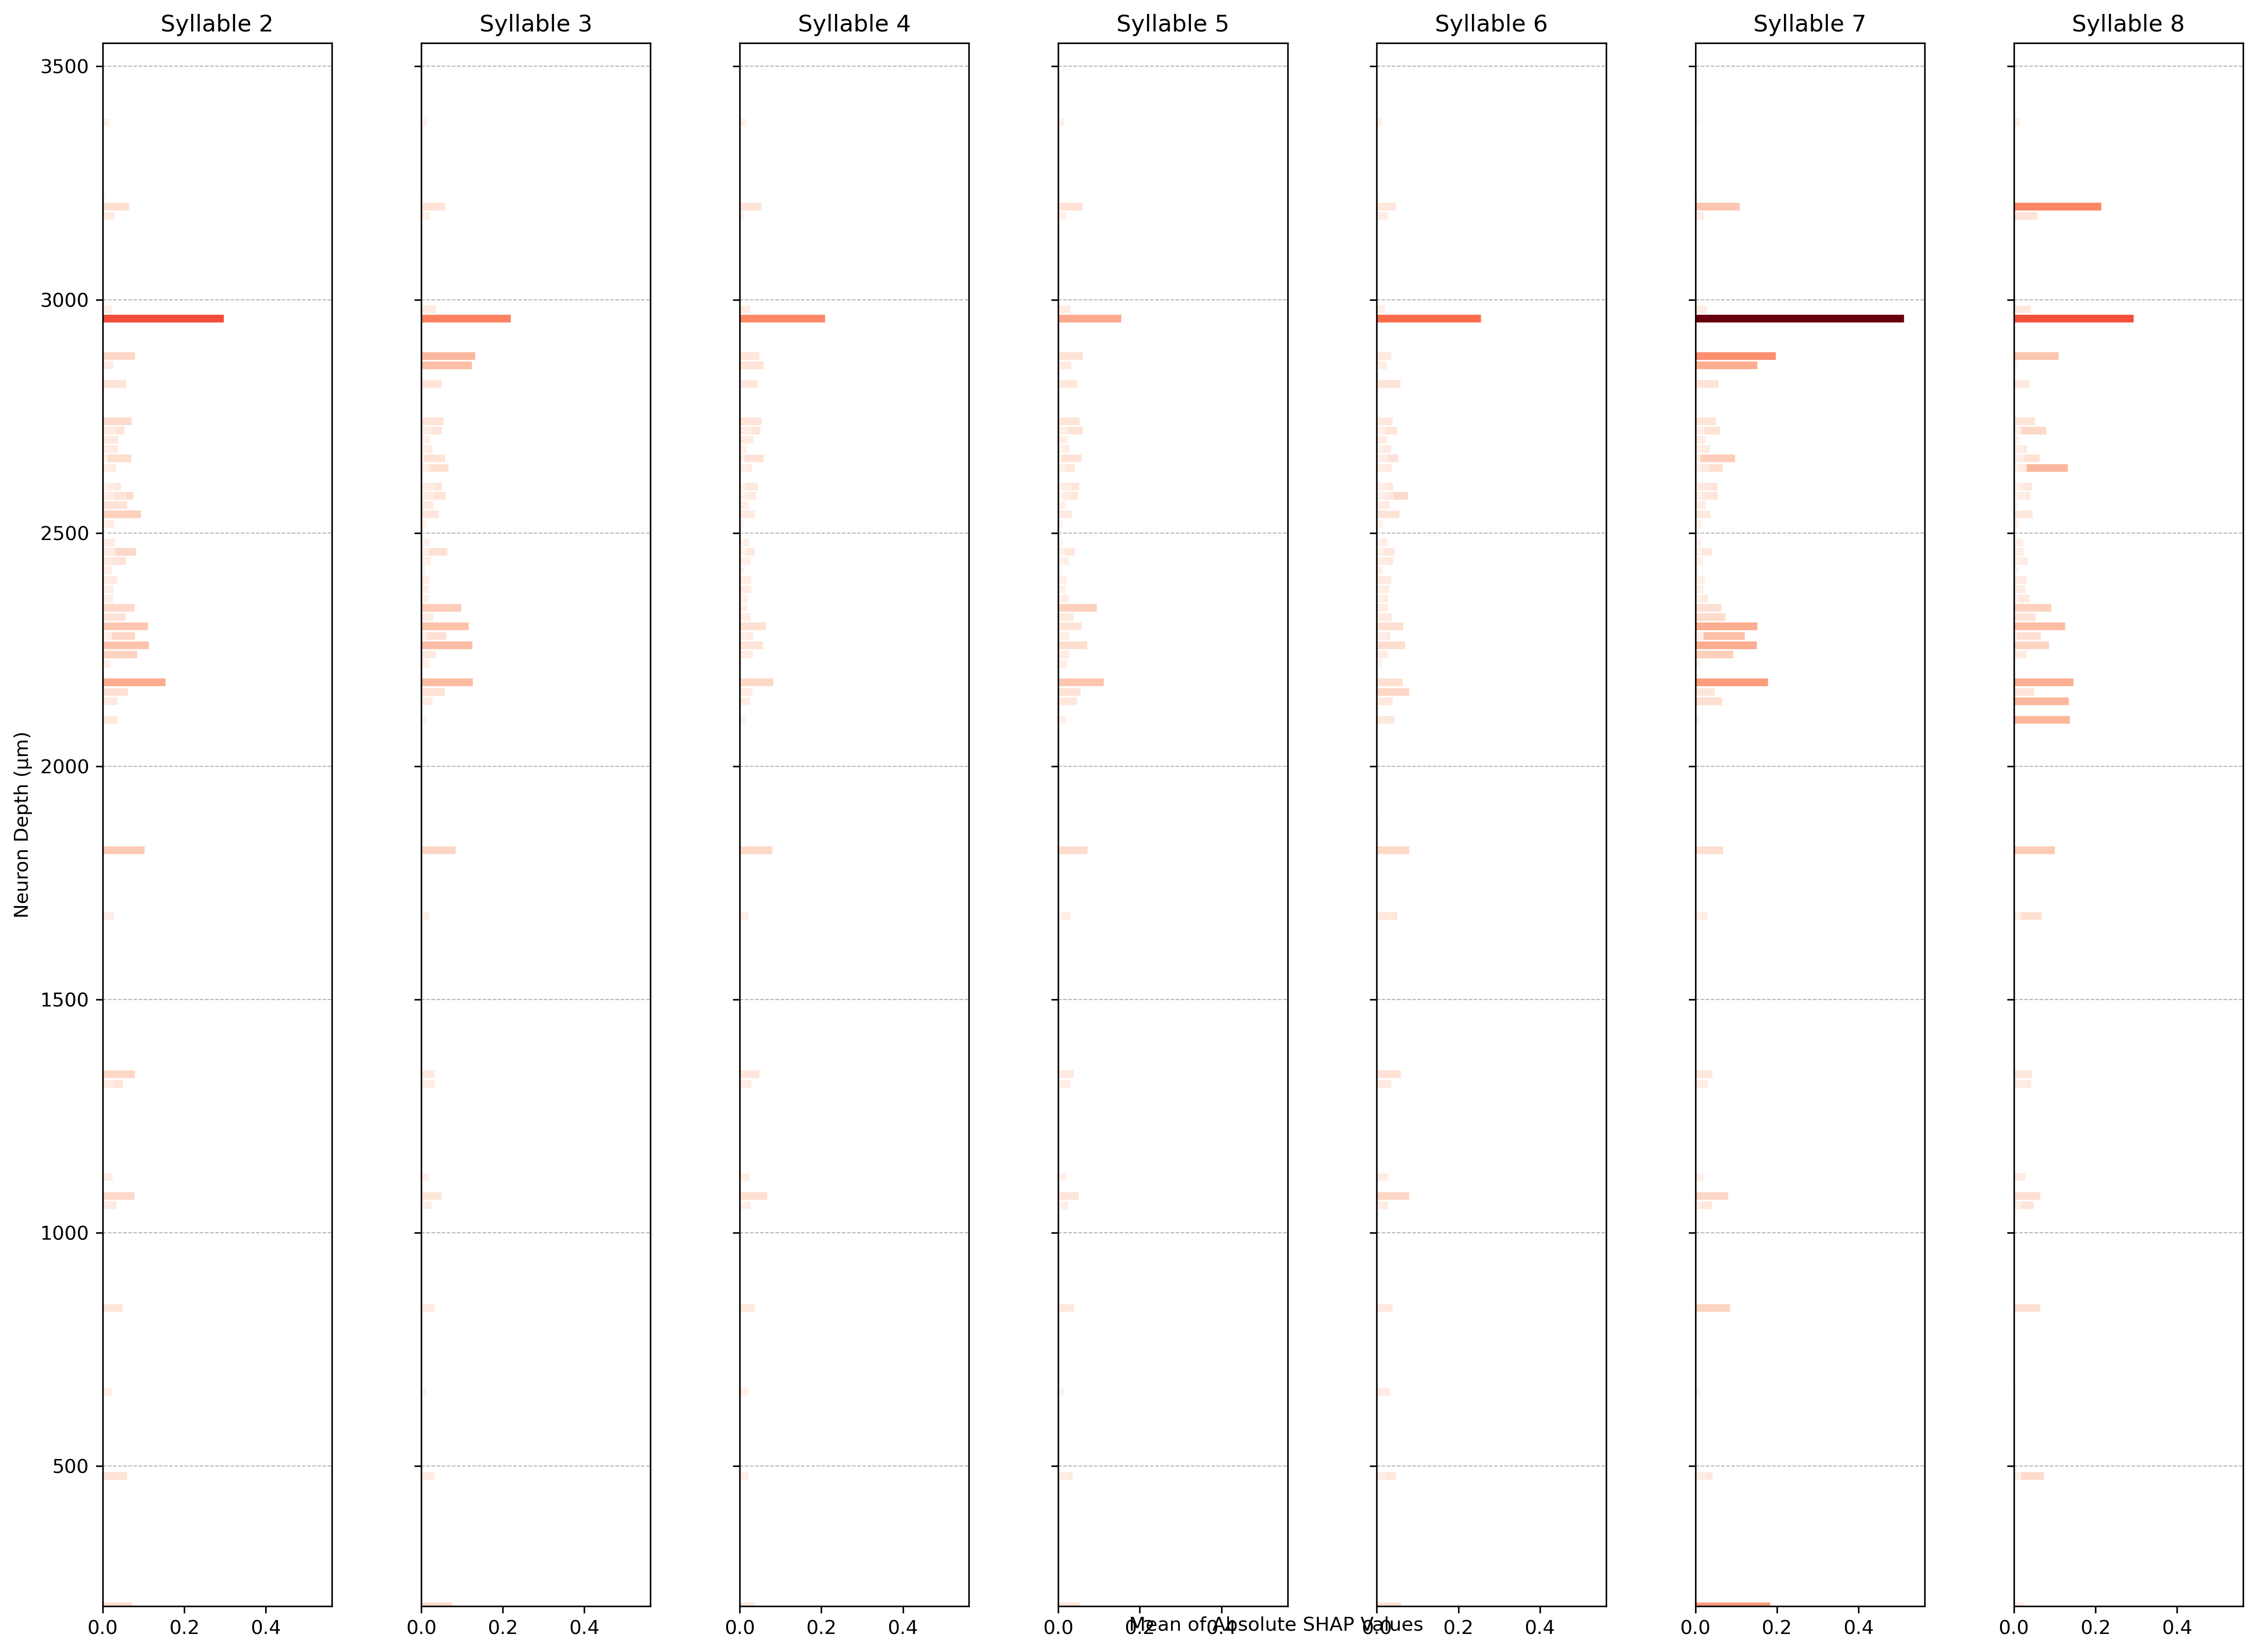


Most important neuron for Syllable 7:
Neuron N42 at depth 2960μm


In [96]:
# Calculate SHAP values for each feature
shap_values = explainer.shap_values(X)

# Create figure with GridSpec
fig = plt.figure(figsize=(24, 12), dpi=300)
gs = GridSpec(1, 61, figure=fig)

# Get min/max for shared normalization
all_shap_values = []
n_classes = len(np.unique(y))
for syllable in range(n_classes):
    syllable_indices = np.where(y == syllable)[0]
    if len(syllable_indices) > 0:
        syllable_shap = np.abs(shap_values[syllable_indices])
        mean_shap = np.mean(syllable_shap, axis=0)
        all_shap_values.extend(mean_shap)
norm = plt.Normalize(np.min(all_shap_values), np.max(all_shap_values))
colormap = plt.cm.Reds

# Plot each syllable class
for syllable in range(n_classes):
    syllable_indices = np.where(y == syllable)[0]
    
    if len(syllable_indices) > 0:
        # Get SHAP values and calculate mean
        syllable_shap = np.abs(shap_values[syllable_indices])
        mean_shap = np.mean(syllable_shap, axis=0)
        
        # Get all features in order of importance
        feature_order = np.argsort(mean_shap)[::-1]
        
        # Create subplot
        ax = fig.add_subplot(gs[:, syllable*6:(syllable+1)*6-1]) 
        
        # Get depths for labels
        depths = [idx2depth[str(idx)] for idx in feature_order]
            
        # Plot horizontal lines for all features
        for i, (depth, importance) in enumerate(zip(depths, mean_shap[feature_order])):
            ax.hlines(
                y=depth,
                xmin=0, 
                xmax=importance,
                colors=colormap(norm(importance)),
                linewidth=4
            )
            
        if syllable == 0:  # Changed from syllable == 2
            ax.set_ylabel('Neuron Depth (μm)')
        else:
            ax.set_yticklabels([])
            
        ax.set_title(f'Syllable {syllable+2}')
        ax.set_xlim(0, max(all_shap_values) * 1.1)
        
        # Set y limits based on min/max depths in idx2depth
        all_depths = [int(v) for v in idx2depth.values()]
        ax.set_ylim(min(all_depths), 3550)  # Not inverted
        
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')

# Add centered x-label for entire figure
fig.text(0.385, 0.02, 'Mean of Absolute SHAP Values', ha='center', va='center')

plt.tight_layout()
plt.savefig('shap_values_across_neurons.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Print most important neuron for syllable 7
syllable_7_indices = np.where(y == 5)[0]  # 5 corresponds to syllable 7
syllable_7_shap = np.abs(shap_values[syllable_7_indices])
mean_shap_7 = np.mean(syllable_7_shap, axis=0)
most_important_idx_7 = np.argmax(mean_shap_7)
depth_7 = idx2depth[str(most_important_idx_7)]

print(f"\nMost important neuron for Syllable 7:")
print(f"Neuron N{most_important_idx_7+1} at depth {depth_7}μm")


In [73]:
print(np.shape(shap_interaction))
# for first data, shape values
feature_names = [f'N{i+1}' for i in range(75)]  # feature names N1-N75
pd.DataFrame(shap_interaction[0], index=feature_names, columns=feature_names)

(3459, 75, 75)


,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,N66,N67,N68,N69,N70,N71,N72,N73,N74,N75
N1,-0.043608,-0.001327,0.000000,0.000000,-0.000250,0.000000,0.006509,0.000000,0.00000,0.000000,...,0.005310,0.000000,0.000000,0.0,-0.001044,0.000000,0.000000,0.000000,0.000000,0.000000
N2,-0.001327,0.033711,0.000000,0.000000,-0.000348,0.009841,0.001395,0.000000,0.00000,0.000000,...,-0.000051,0.000000,0.000000,0.0,0.001346,0.000000,0.000000,-0.006599,0.000000,0.000000
N3,0.000000,0.000000,0.044213,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
N4,0.000000,0.000000,0.000000,-0.133908,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.001882,0.000000,0.000000
N5,-0.000250,-0.000348,0.000000,0.000000,-0.002175,-0.000132,0.000000,0.000000,0.00000,0.000000,...,0.000000,-0.000344,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N71,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.013436,0.000000,-0.002153,0.0,0.008057,-0.031434,0.000000,0.000000,0.000000,0.000000
N72,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-0.000682,0.000000,0.000000,0.000000
N73,0.000000,-0.006599,0.000000,0.001882,0.000000,0.000000,0.000000,0.001188,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.016137,0.000000,0.000000
N74,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.00895,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-0.105785,0.000000


In [74]:
# Get depths and create mapping from current index to depth-sorted index
depths = [idx2depth[str(i)] for i in range(75)]
depth_idx_pairs = list(enumerate(depths))

# Sort by depth . descending order
sorted_pairs = sorted(depth_idx_pairs, key=lambda x: x[1], reverse=True)  # reverse=True

# mapping: new_index -> old_index
new_to_old_idx = {new_idx: old_idx for new_idx, (old_idx, _) in enumerate(sorted_pairs)}

# mean of matrices
mean_shap = shap_interaction.mean(0)

# feature names based on depth order (N1 = deepest)
feature_names = [f'N{i+1}' for i in range(75)]  # Simple 1-75 numbering for deepest to shallowest

# Reorder rows and columns based on depth
reorder_idx = [pair[0] for pair in sorted_pairs]
reordered_mean_shap = mean_shap[reorder_idx][:, reorder_idx]
df = pd.DataFrame(reordered_mean_shap, index=feature_names, columns=feature_names)

# times off diagonal by 2
df.where(df.values == np.diagonal(df), df.values*2, inplace=True)

# Print first few depths
for i in range(75):
    old_idx = new_to_old_idx[i]
    depth = idx2depth[str(old_idx)]
    print(f"N{i+1}: {depth}μm")  # N1 will be the deepest

N1: 3380μm
N2: 3220μm
N3: 3200μm
N4: 3180μm
N5: 2980μm
N6: 2960μm
N7: 2880μm
N8: 2860μm
N9: 2820μm
N10: 2740μm
N11: 2720μm
N12: 2720μm
N13: 2700μm
N14: 2680μm
N15: 2680μm
N16: 2660μm
N17: 2660μm
N18: 2640μm
N19: 2640μm
N20: 2640μm
N21: 2600μm
N22: 2600μm
N23: 2600μm
N24: 2600μm
N25: 2580μm
N26: 2580μm
N27: 2580μm
N28: 2580μm
N29: 2580μm
N30: 2560μm
N31: 2540μm
N32: 2540μm
N33: 2520μm
N34: 2520μm
N35: 2500μm
N36: 2480μm
N37: 2480μm
N38: 2460μm
N39: 2460μm
N40: 2440μm
N41: 2440μm
N42: 2420μm
N43: 2400μm
N44: 2380μm
N45: 2380μm
N46: 2360μm
N47: 2360μm
N48: 2340μm
N49: 2320μm
N50: 2300μm
N51: 2280μm
N52: 2280μm
N53: 2260μm
N54: 2240μm
N55: 2220μm
N56: 2180μm
N57: 2160μm
N58: 2140μm
N59: 2100μm
N60: 1880μm
N61: 1820μm
N62: 1680μm
N63: 1680μm
N64: 1340μm
N65: 1320μm
N66: 1320μm
N67: 1120μm
N68: 1080μm
N69: 1060μm
N70: 1060μm
N71: 840μm
N72: 660μm
N73: 480μm
N74: 480μm
N75: 200μm


In [75]:
df

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,N66,N67,N68,N69,N70,N71,N72,N73,N74,N75
N1,-0.000737,0.000000,0.000000,0.000000,0.000000,-0.000377,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
N2,0.000000,0.000087,0.000000,0.000000,0.000000,0.000000,0.0,0.000007,0.0,0.000000,...,0.0,-0.000001,8.423162e-07,0.0,-0.000144,0.000002,0.000157,0.000018,0.000000,0.000000
N3,0.000000,0.000000,-0.000466,0.000000,0.000000,-0.002347,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.000000,-0.000475,0.000385,0.000000
N4,0.000000,0.000000,0.000000,0.000752,0.000000,0.000000,0.0,0.000000,0.0,-0.000268,...,0.0,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
N5,0.000000,0.000000,0.000000,0.000000,-0.001012,0.000000,0.0,0.000000,0.0,0.000792,...,0.0,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.000294,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N71,0.000000,0.000002,0.000000,0.000000,0.000000,-0.001288,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000e+00,0.0,0.000000,-0.001249,0.000454,0.000000,0.000000,0.000476
N72,0.000000,0.000157,0.000000,0.000000,0.000000,-0.000158,0.0,-0.000105,0.0,0.000000,...,0.0,0.000000,0.000000e+00,0.0,0.000000,0.000454,-0.000358,-0.000443,0.000000,0.000000
N73,0.000000,0.000018,-0.000475,0.000000,0.000000,0.000408,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000e+00,0.0,0.000000,0.000000,-0.000443,-0.000145,0.000000,0.000000
N74,0.000000,0.000000,0.000385,0.000000,0.000294,-0.000043,0.0,0.000000,0.0,-0.000350,...,0.0,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,-0.000221,0.000900


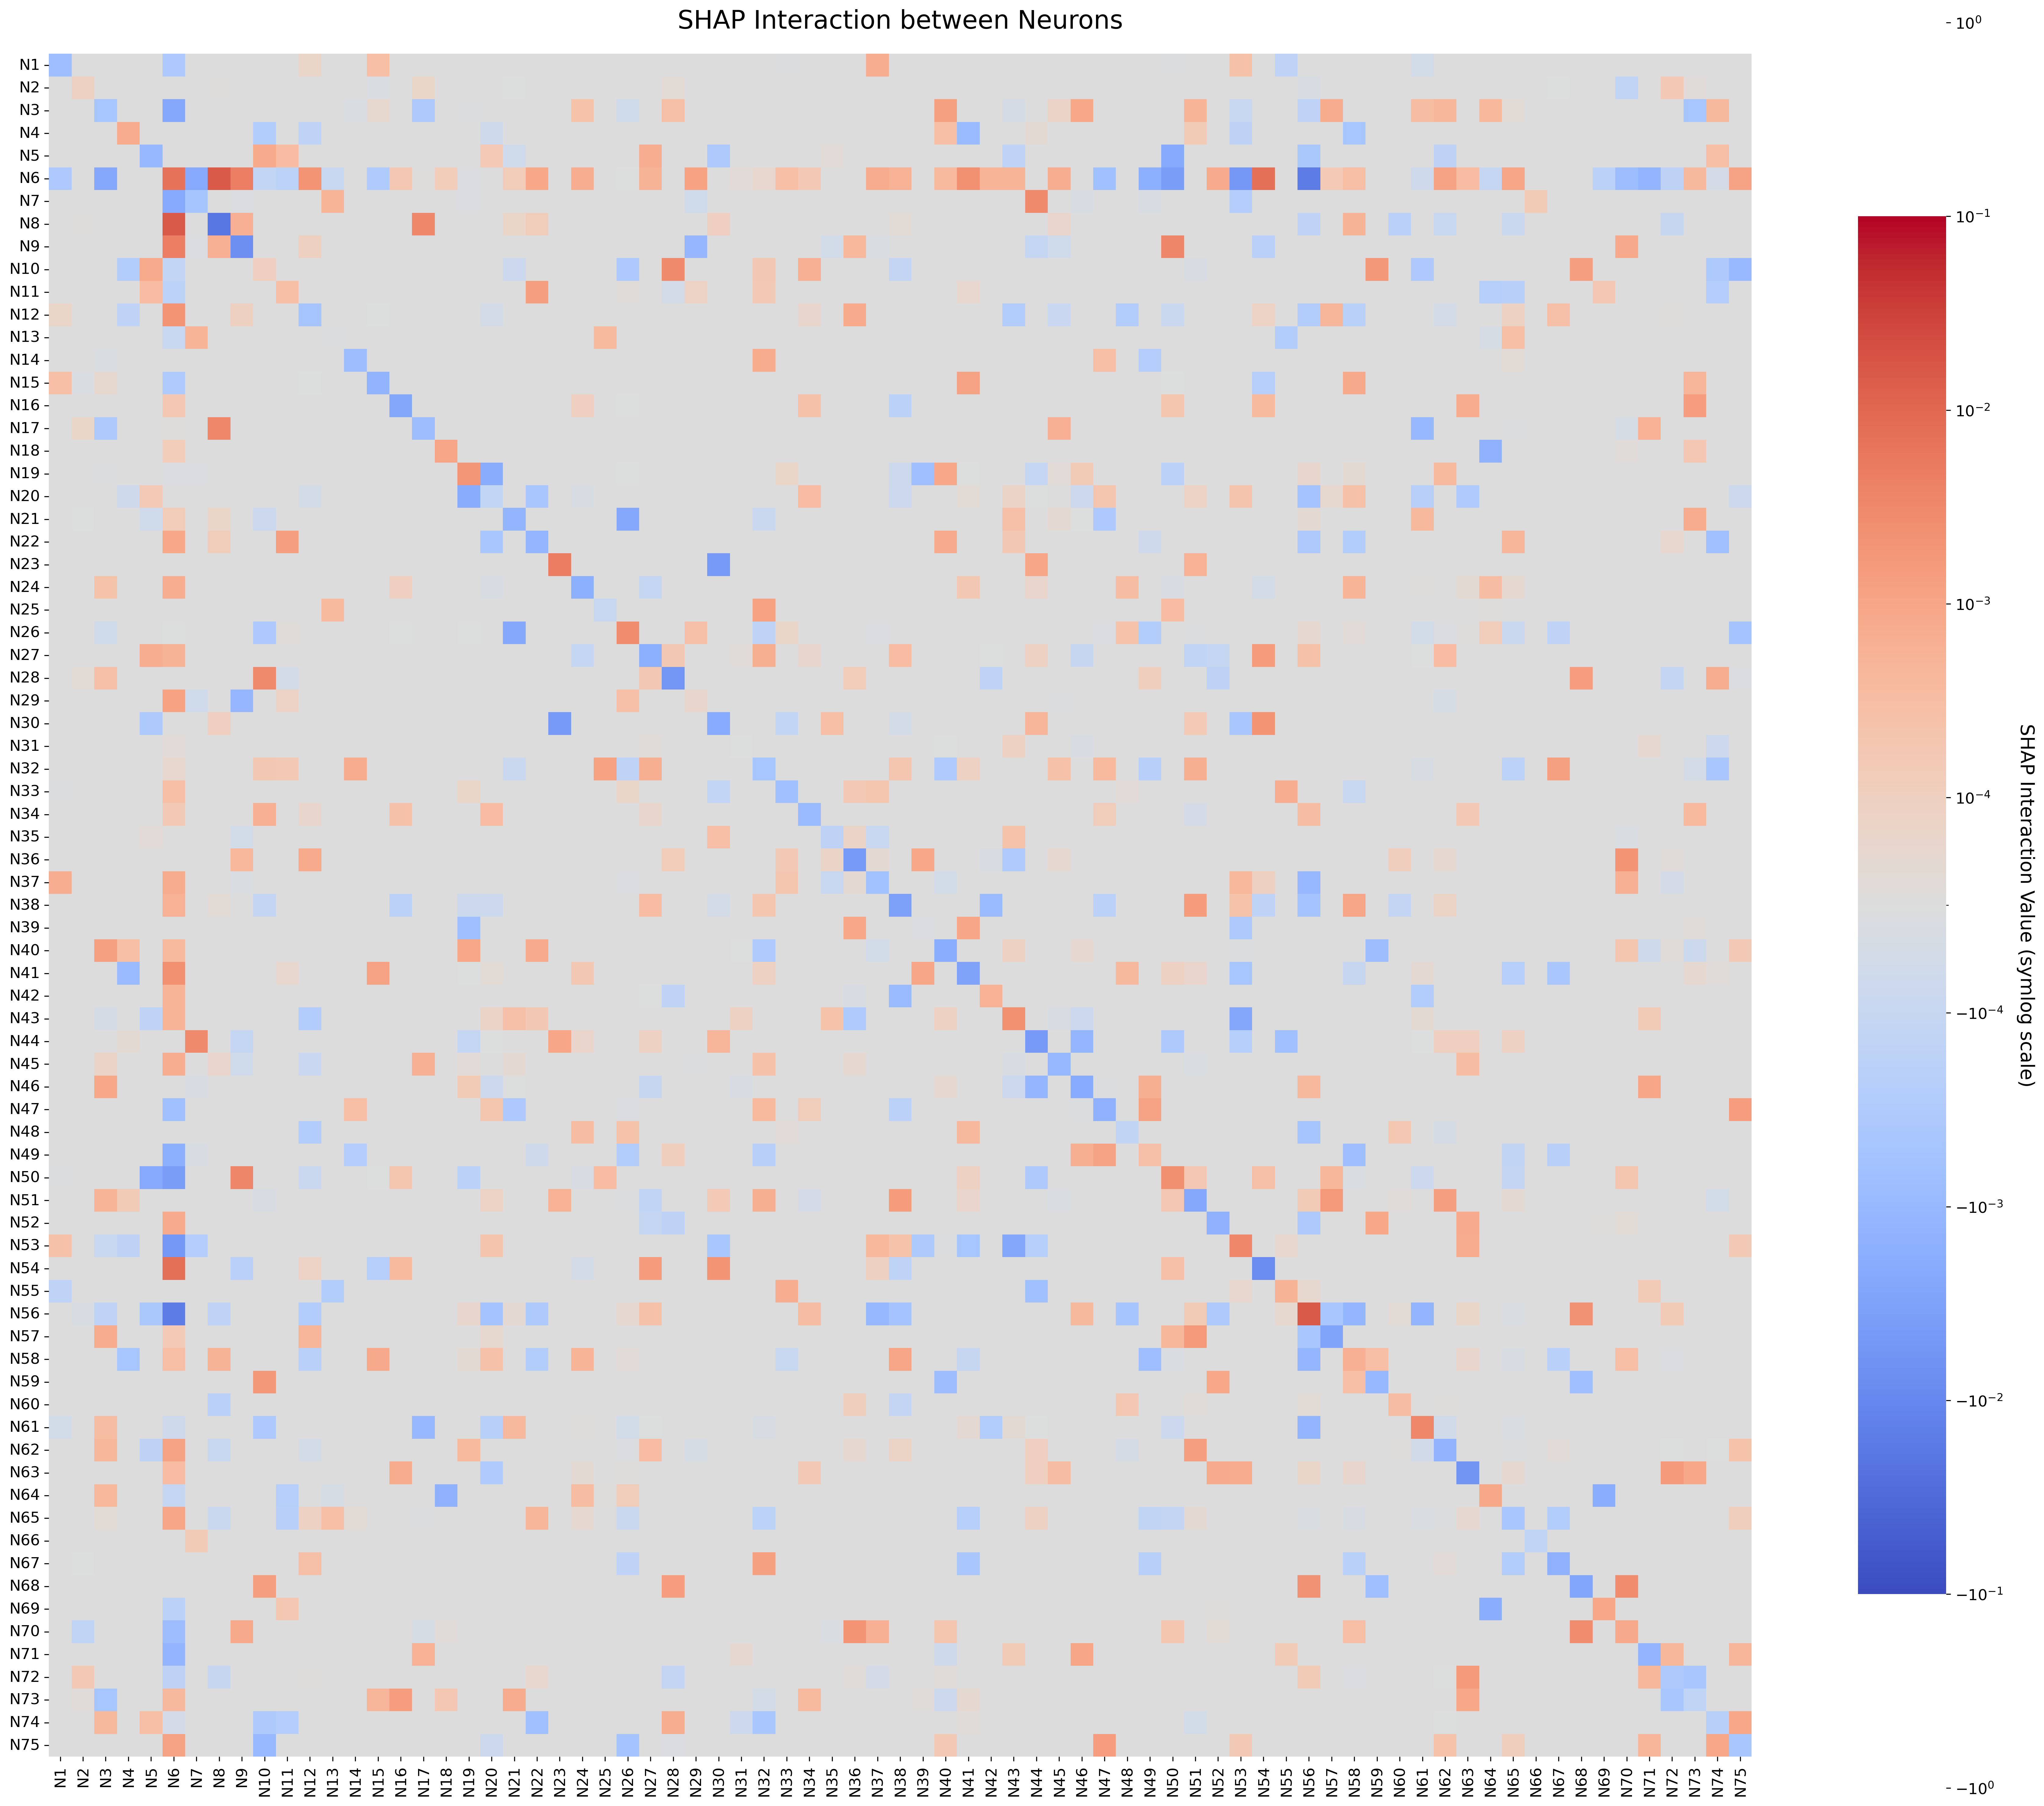

In [135]:
fig, ax = plt.subplots(figsize=(24, 20), dpi=300)

linthresh = 1e-4  
linscale = 0.5   

norm = mcolors.SymLogNorm(
    linthresh=linthresh, linscale=linscale, vmin=-0.1, vmax=0.1
)

heatmap = sns.heatmap(
    df,
    cmap='coolwarm',
    annot=False,
    cbar=True,
    norm=norm,
    square=True,
    ax=ax,
    center=None  # Remove centering at zero
)

ax.set_title('SHAP Interaction between Neurons', pad=20, fontsize=20)
ax.set_xticks(np.arange(len(feature_names)) + 0.5)
ax.set_yticks(np.arange(len(feature_names)) + 0.5)
ax.set_xticklabels(feature_names, rotation=90, ha='center', fontsize=12)
ax.set_yticklabels(feature_names, rotation=0, va='center', fontsize=12)

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)  # tick label size
# Remove zero from colorbar ticks
cbar.set_ticks([tick for tick in cbar.get_ticks() if tick != 0])
cbar.set_label(
    'SHAP Interaction Value (symlog scale)', size=15, rotation=270, labelpad=25
) 


plt.tight_layout()
plt.savefig(
    'SHAP_interaction_adjusted.pdf',
    dpi=300,
    bbox_inches='tight',
    facecolor='none', 
    edgecolor='none'
)

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(24, 20), dpi=300)

# heatmap with linear scale
heatmap = sns.heatmap(
    df,
    cmap='coolwarm',
    annot=False,
    cbar=True,
    square=True,
    ax=ax,
    center=None,  # remove centering at zero
    vmin=-0.1,   
    vmax=0.1
)


ax.set_title('SHAP Interaction between Neurons', pad=20, fontsize=20)
ax.set_xticks(np.arange(len(feature_names)) + 0.5)
ax.set_yticks(np.arange(len(feature_names)) + 0.5)
ax.set_xticklabels(feature_names, rotation=90, ha='center', fontsize=12)
ax.set_yticklabels(feature_names, rotation=0, va='center', fontsize=12)

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)  
cbar.set_label(
    'SHAP Interaction Value', size=15, rotation=270, labelpad=25
)  

plt.tight_layout()

plt.savefig(
    'SHAP_interaction_adjusted.pdf',
    dpi=300,
    bbox_inches='tight',
    facecolor='none', 
    edgecolor='none'
)

plt.show()

In [77]:
flat_df = df.values.flatten()
sorted_indices = np.argsort(np.abs(flat_df))[::-1]
top_pairs = []
seen_pairs = set()

for idx in sorted_indices:
    row, col = idx // 75, idx % 75
    if row != col:
        pair = tuple(sorted([row, col]))
        if pair not in seen_pairs and len(top_pairs) < 10:
            top_pairs.append((row, col))
            seen_pairs.add(pair)
            
            # verification info
            n1, n2 = pair
            old_idx1 = new_to_old_idx[n1]
            old_idx2 = new_to_old_idx[n2]
            depth1 = idx2depth[str(old_idx1)]
            depth2 = idx2depth[str(old_idx2)]
            interaction_value = df.iloc[n1, n2]
            
            print(f"Pair N{n1+1}-N{n2+1}: depths {depth1}-{depth2}μm, interaction value: {interaction_value:.6f}")

Pair N6-N56: depths 2960-2180μm, interaction value: -0.016124
Pair N6-N8: depths 2960-2860μm, interaction value: 0.014989
Pair N6-N54: depths 2960-2240μm, interaction value: 0.007441
Pair N6-N53: depths 2960-2260μm, interaction value: -0.005254
Pair N23-N30: depths 2600-2560μm, interaction value: -0.004578
Pair N6-N9: depths 2960-2820μm, interaction value: 0.004439
Pair N6-N50: depths 2960-2300μm, interaction value: -0.004024
Pair N9-N50: depths 2820-2300μm, interaction value: 0.003415
Pair N8-N17: depths 2860-2660μm, interaction value: 0.003266
Pair N10-N28: depths 2740-2580μm, interaction value: 0.003117


C:\Users\askrb\AppData\Local\Temp\ipykernel_32416\181790913.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 1])


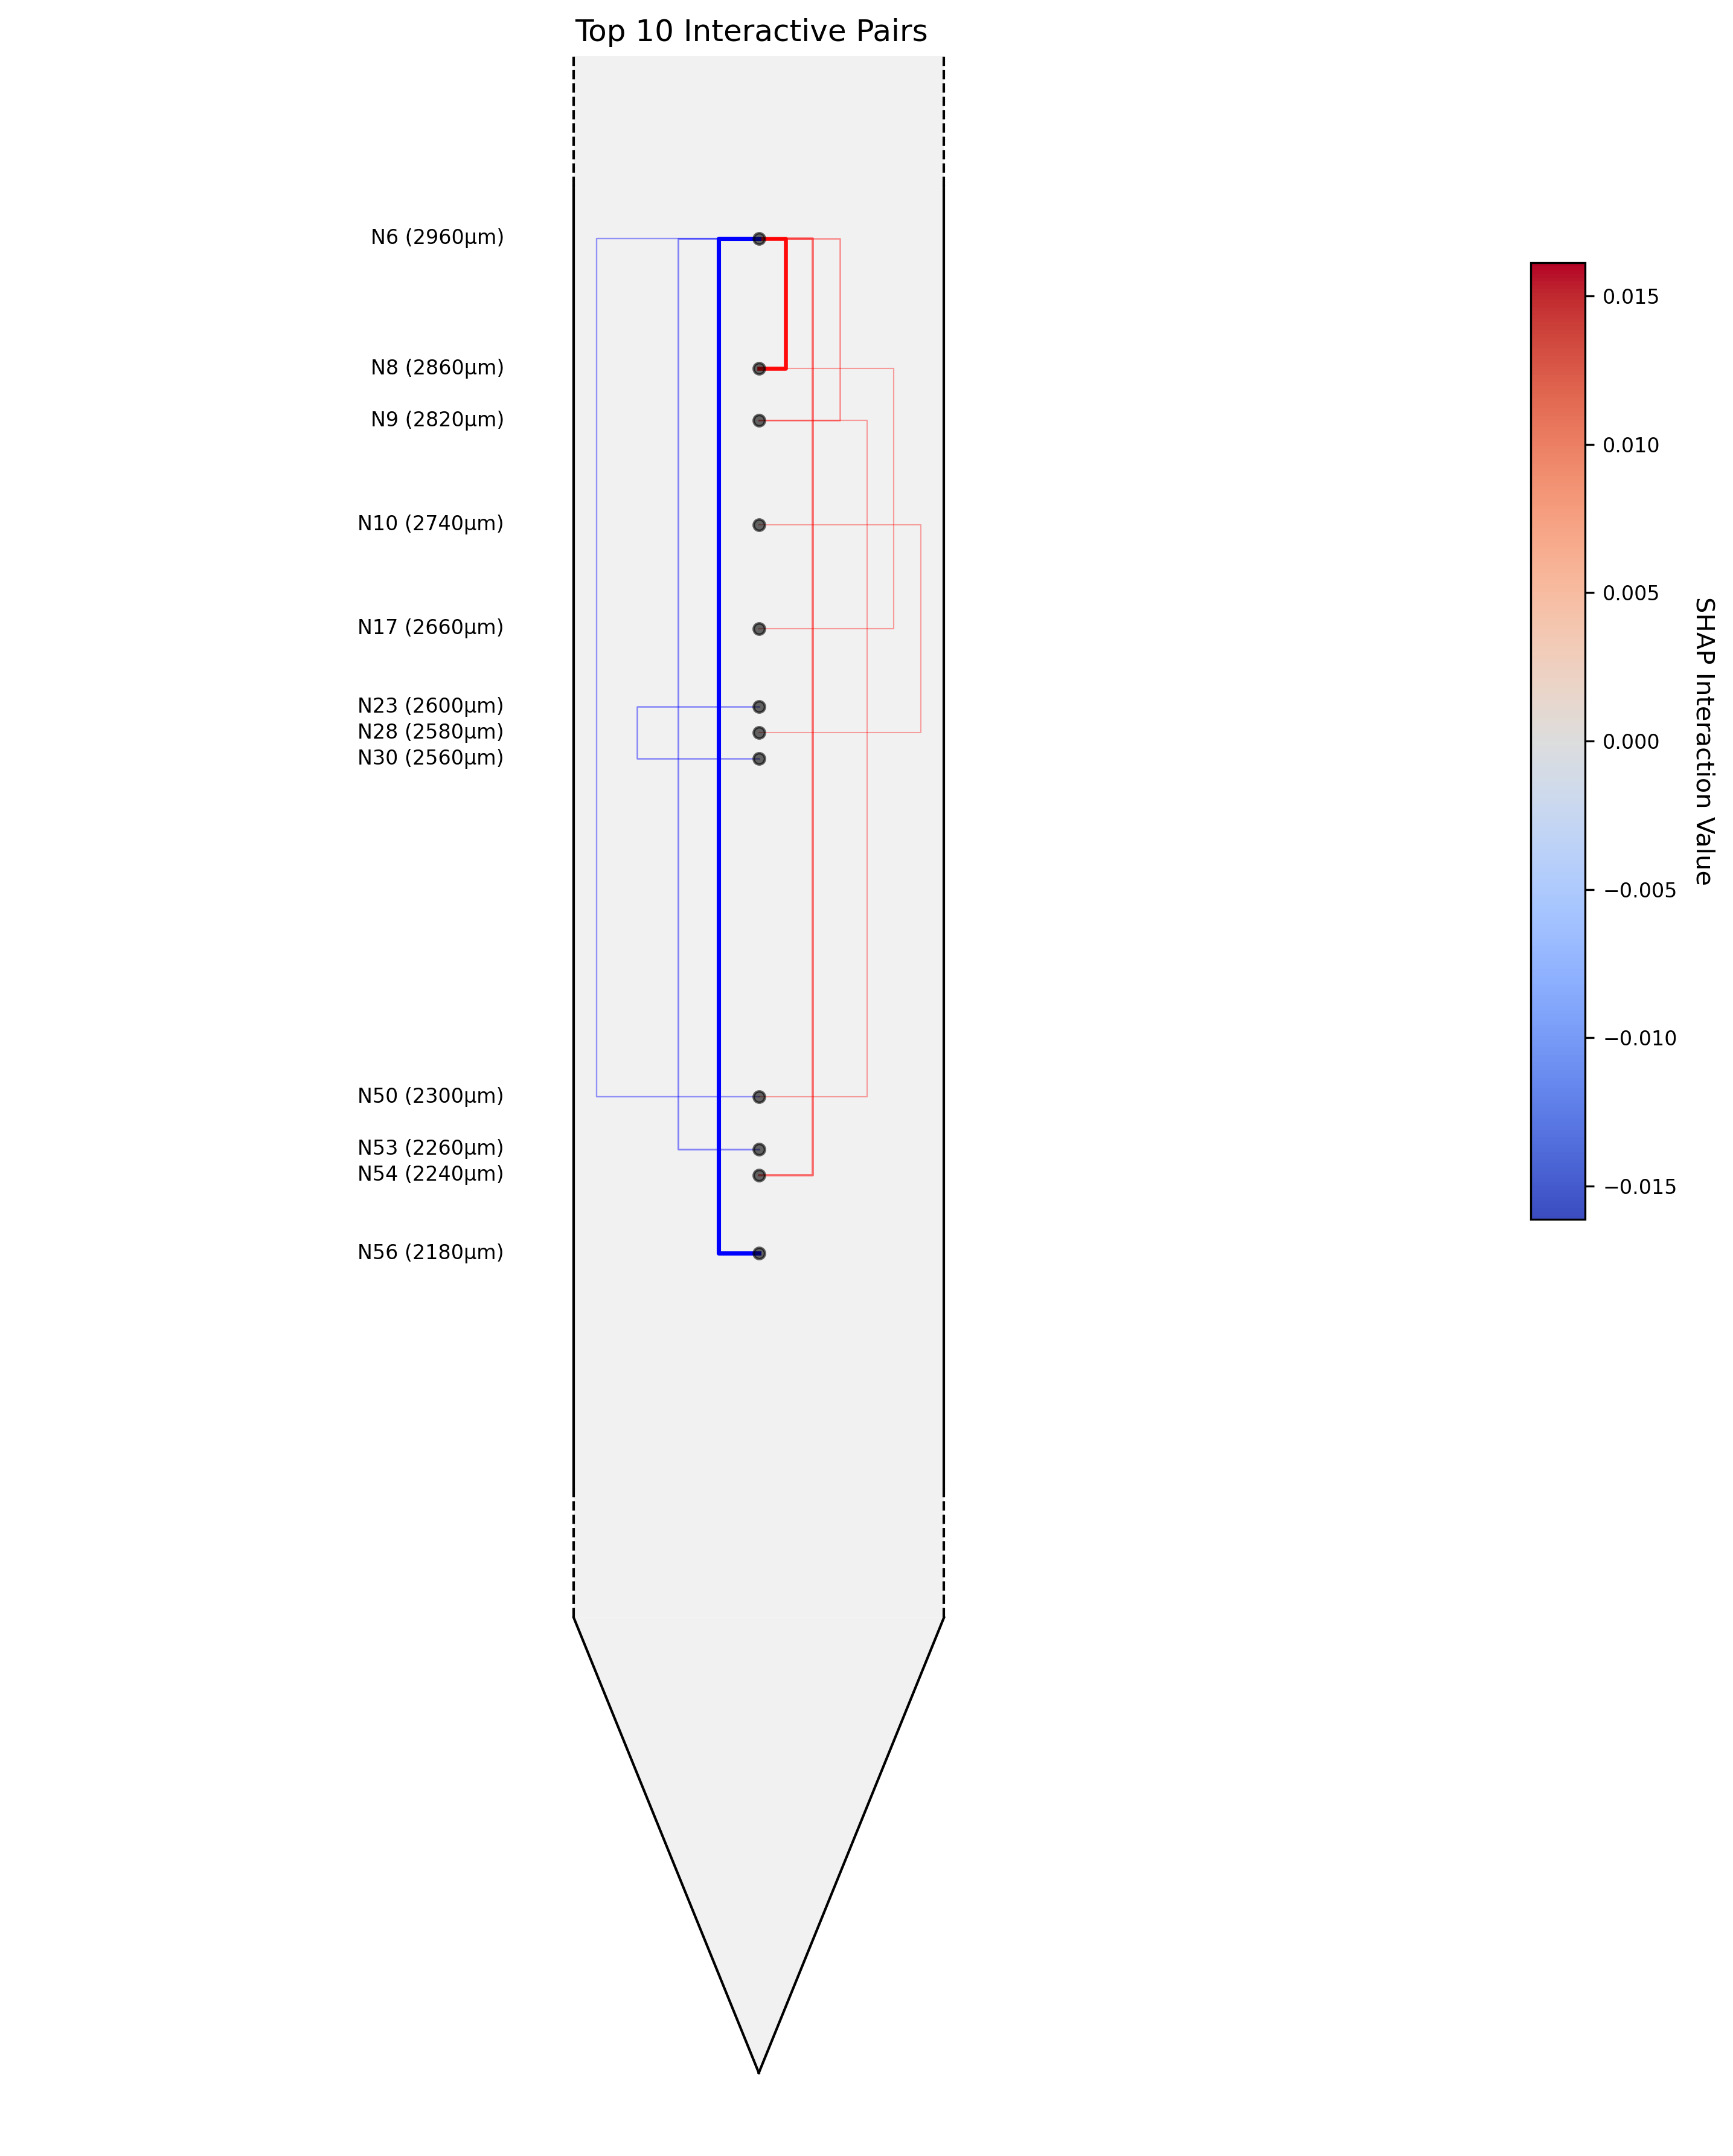

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(10, 12), dpi=300)

# probe dimensions
probe_width = 0.8
x_center = 2

# draw main probe body
ax.plot([x_center-probe_width/2, x_center-probe_width/2], [2000, 3000], '-', color='black', linewidth=1)
ax.plot([x_center+probe_width/2, x_center+probe_width/2], [2000, 3000], '-', color='black', linewidth=1)

# fill with gray
ax.fill([x_center-probe_width/2, x_center+probe_width/2, 
         x_center+probe_width/2, x_center-probe_width/2],
        [2000, 2000, 3000, 3000],
        color='lightgray',edgecolor='none', alpha=0.3, zorder=0)

# bottom section
ax.fill([x_center-probe_width/2, x_center+probe_width/2, 
         x_center+probe_width/2, x_center-probe_width/2],
        [1900, 1900, 2000, 2000],
        color='lightgray', edgecolor='none',alpha=0.3, zorder=0)

# top section 
ax.fill([x_center-probe_width/2, x_center+probe_width/2, 
         x_center+probe_width/2, x_center-probe_width/2],
        [3000, 3000, 3100, 3100],
        color='lightgray', edgecolor='none',alpha=0.3, zorder=0)

# dashed lines for extended parts
ax.plot([x_center-probe_width/2, x_center-probe_width/2], [1900, 2000], '--', color='black', linewidth=1)
ax.plot([x_center+probe_width/2, x_center+probe_width/2], [1900, 2000], '--', color='black', linewidth=1)
ax.plot([x_center-probe_width/2, x_center-probe_width/2], [3000, 3100], '--', color='black', linewidth=1)
ax.plot([x_center+probe_width/2, x_center+probe_width/2], [3000, 3100], '--', color='black', linewidth=1)

# probe tip
ax.plot([x_center-probe_width/2, x_center], [1900, 1550], '-', color='black', linewidth=1)
ax.plot([x_center, x_center+probe_width/2], [1550, 1900], '-', color='black', linewidth=1)
ax.fill([x_center-probe_width/2, x_center, x_center+probe_width/2],
        [1900, 1550, 1900],
        color='lightgray',edgecolor='none', alpha=0.3, zorder=0)

max_abs_interaction = max(abs(df.iloc[n1, n2]) for n1, n2 in top_pairs)

# track unique pairs
seen_pairs = set()
pos_pairs = []
neg_pairs = []

for n1, n2 in top_pairs:
    old_idx1 = new_to_old_idx[n1]
    old_idx2 = new_to_old_idx[n2]
    depth1 = idx2depth[str(old_idx1)]
    depth2 = idx2depth[str(old_idx2)]
    interaction_value = df.iloc[n1, n2]
    
    pair = frozenset([n1, n2])
    if pair not in seen_pairs and (2000 <= depth1 <= 3000 or 2000 <= depth2 <= 3000):
        seen_pairs.add(pair)
        if interaction_value > 0:
            pos_pairs.append((n1, n2, depth1, depth2, interaction_value))
        else:
            neg_pairs.append((n1, n2, depth1, depth2, interaction_value))

# get unique neurons
unique_neurons = set()
for pair in seen_pairs:
    n1, n2 = pair
    unique_neurons.add(n1)
    unique_neurons.add(n2)

# plot neurons
for n in unique_neurons:
    old_idx = new_to_old_idx[n]
    depth = idx2depth[str(old_idx)]
    
    if 2000 <= depth <= 3000:
        ax.scatter(x_center, depth,
                  s=20,
                  c='black',
                  alpha=0.6,
                  zorder=2)
        
        ax.text(x_center-probe_width/2-0.15, depth, f'N{n+1} ({depth}μm)',
                verticalalignment='center',
                horizontalalignment='right',
                fontsize=8)

# setup colormap
norm = plt.Normalize(vmin=-max_abs_interaction, vmax=max_abs_interaction)
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)

max_offset = 0.5

# draw interaction lines
for i, (pairs, direction) in enumerate([(pos_pairs, 1), (neg_pairs, -1)]):
    for j, (n1, n2, depth1, depth2, interaction_value) in enumerate(pairs):
        normalized_value = abs(interaction_value) / max_abs_interaction
        alpha = 0.2 + 0.8 * normalized_value
        width = 0.2 + 1.5 * normalized_value
        
        x_offset = direction * max_offset * ((j + 1) / len(pairs)) * 0.7
        
        ax.plot([x_center, x_center + x_offset, x_center + x_offset, x_center], 
                [depth1, depth1, depth2, depth2],
                color='red' if interaction_value > 0 else 'blue',
                alpha=alpha,
                linewidth=width,
                zorder=1)

# colorbar
cax = fig.add_axes([0.85, 0.435, 0.03, 0.44])
cbar = plt.colorbar(sm, cax=cax, label='Shap Interaction')
cbar.ax.tick_params(labelsize=8)
cbar.set_label('SHAP Interaction Value', size=10, rotation=270, labelpad=15)

# cleanup plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False) 
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Top 10 Interactive Pairs', fontsize=12, x=0.44)

ax.set_xlim(x_center-probe_width-0.8, x_center+probe_width+1.2)
ax.set_ylim(1500, 3100)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
plt.tight_layout(rect=[0, 0, 0.95, 1])

plt.savefig('neuron_interactions.pdf', dpi=300, bbox_inches='tight', edgecolor='none')
plt.show()

# Correlation and others

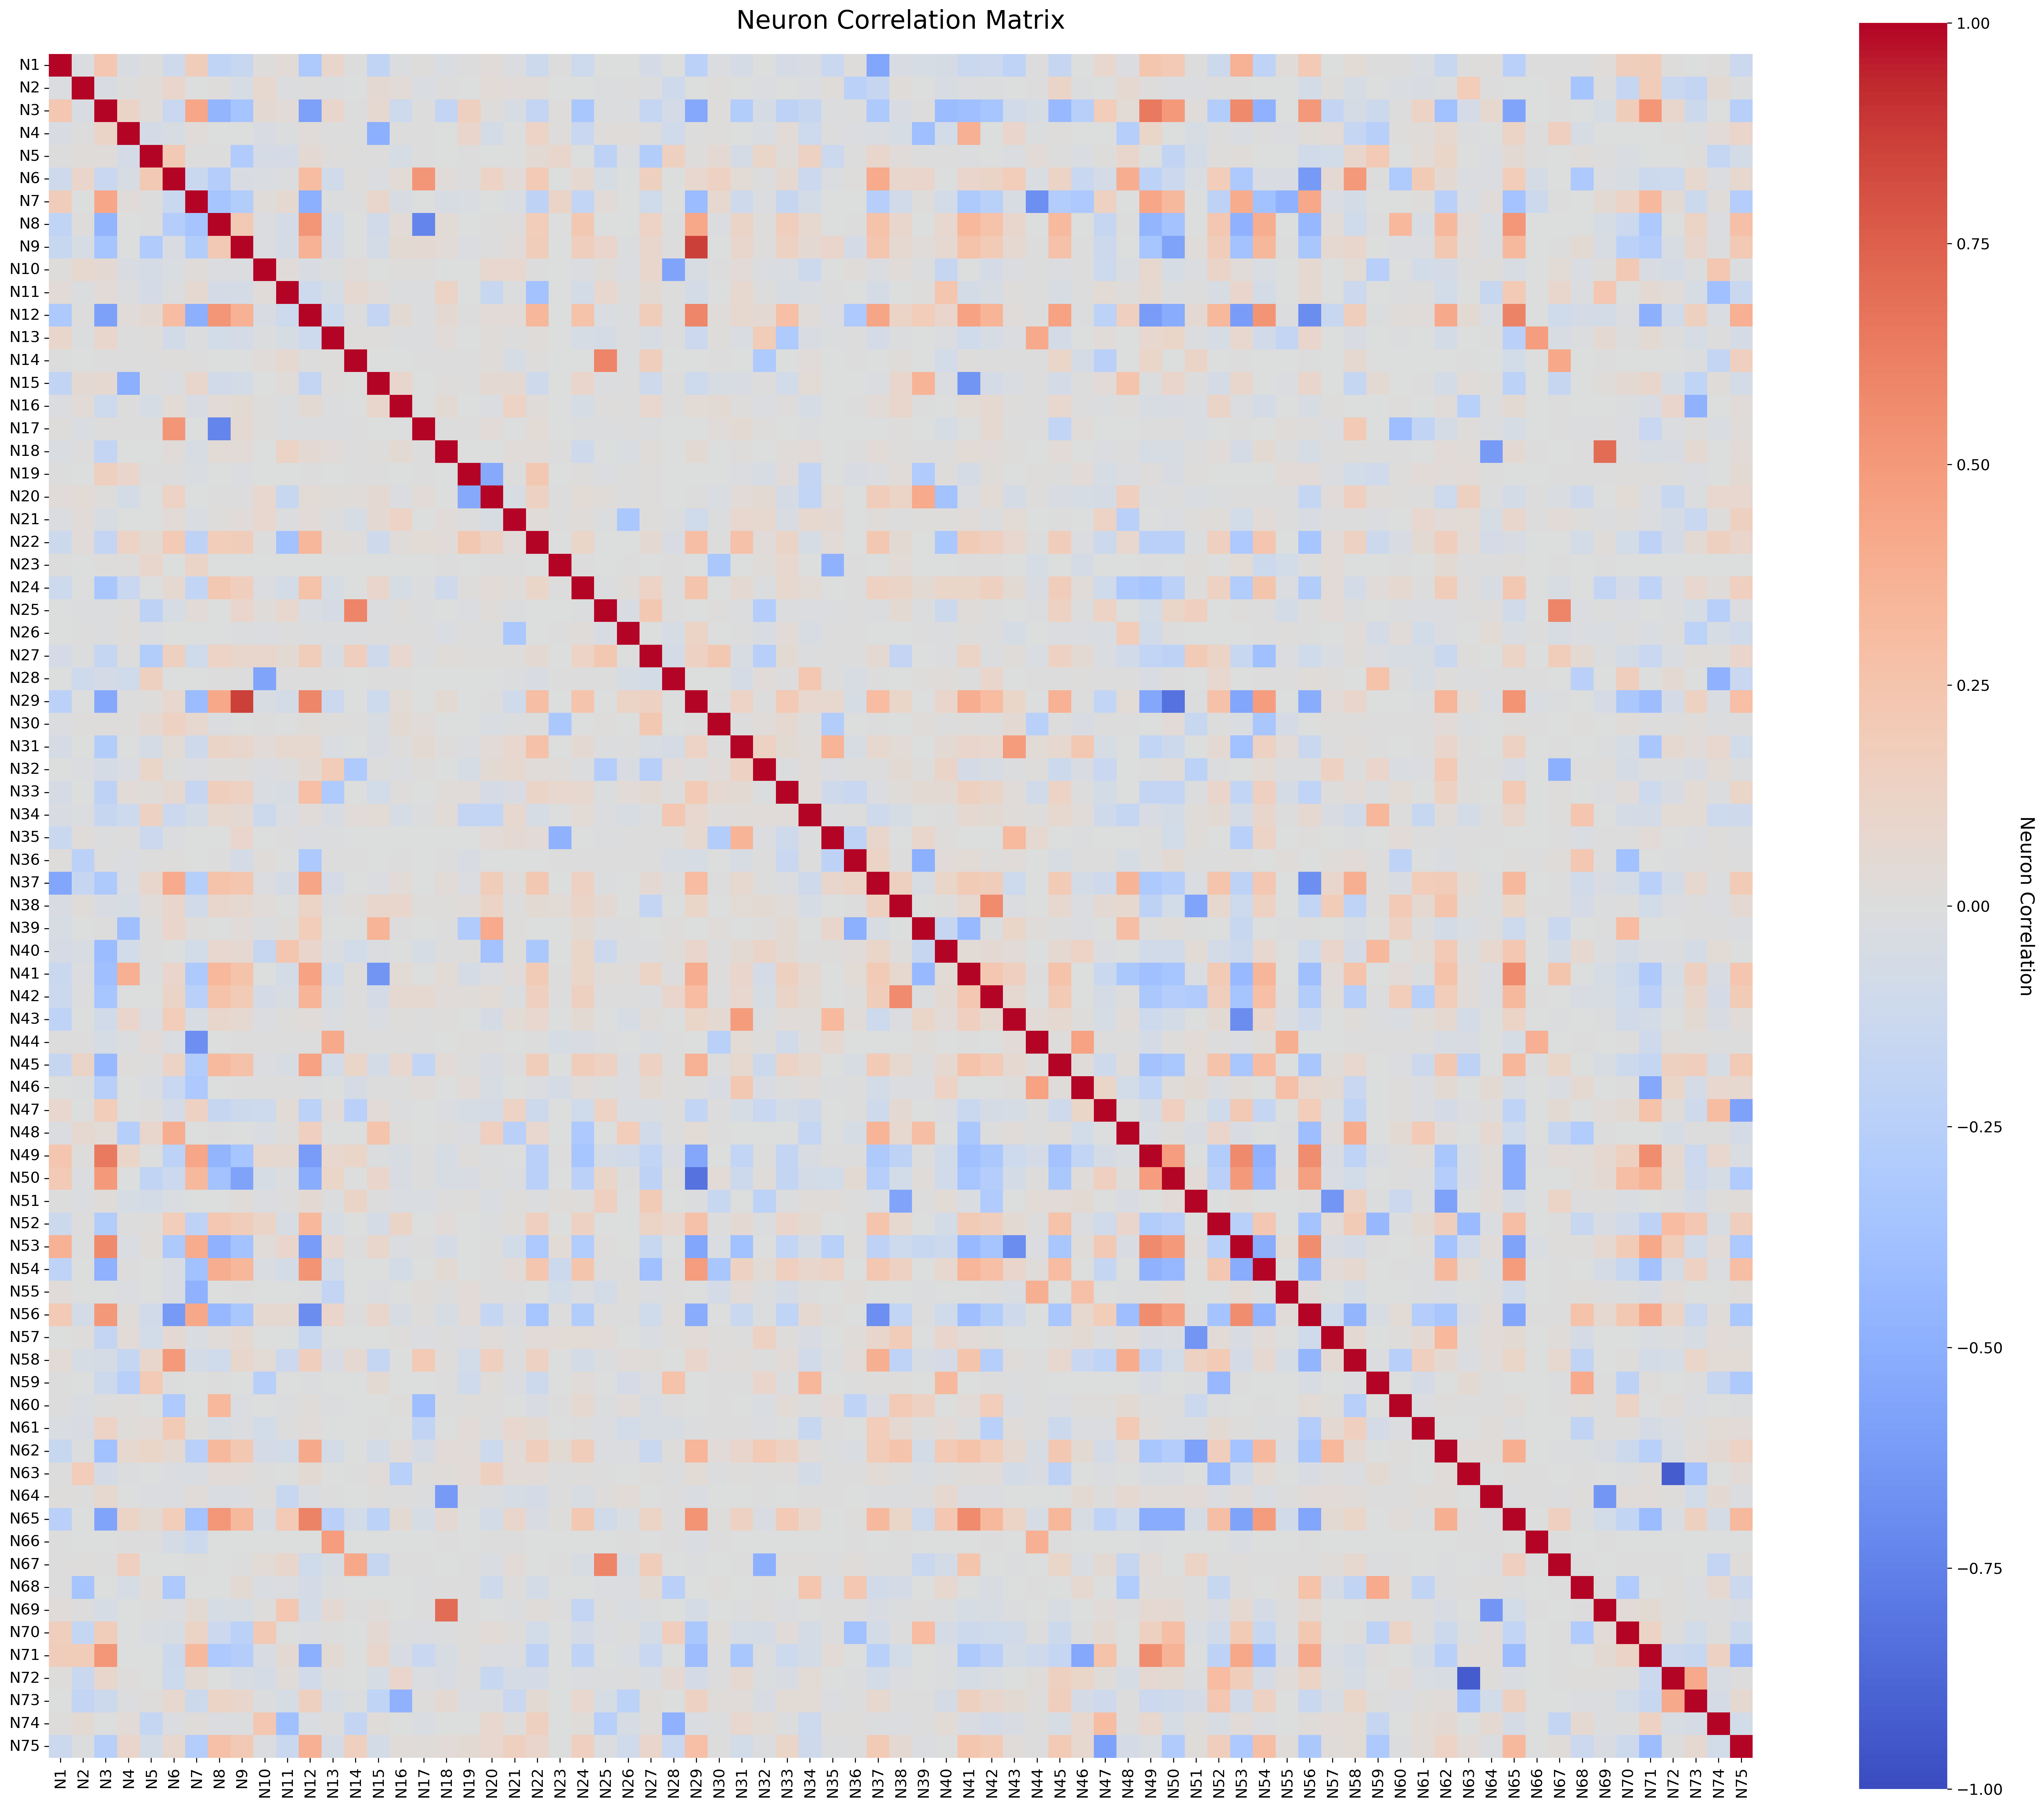

In [126]:
correlation_matrix = df.corr()

fig, ax = plt.subplots(figsize=(24, 20), dpi=300)

heatmap = sns.heatmap(correlation_matrix,
                      cmap='coolwarm',
                      annot=False,
                      cbar=True,
                      vmin=-1,
                      vmax=1,
                      square=True,
                      ax=ax)

ax.set_title('Neuron Correlation Matrix',
             pad=20,
             fontsize=20)

feature_names = correlation_matrix.columns
ax.set_xticks(np.arange(len(feature_names))+0.5)
ax.set_yticks(np.arange(len(feature_names))+0.5)
ax.set_xticklabels(feature_names, rotation=90, ha='center', fontsize=12)
ax.set_yticklabels(feature_names, rotation=0, va='center', fontsize=12)

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Neuron Correlation',
               size=15,
               rotation=270,
               labelpad=25)

plt.tight_layout()

plt.savefig('feature_correlation.pdf',
            dpi=300,
            bbox_inches='tight',
            facecolor='none',
            edgecolor='none')